In [279]:
options(repr.matrix.max.rows=100, repr.matrix.max.cols=300)
options(repr.plot.width = 20, repr.plot.height = 15)
options(width=300)

numcores=8

library(tidyverse)
library(parallel)
library(data.table)
library(fst)
library(comorbidity)
library(zeallot)
library(reshape)
library(dtplyr)
library(haven)
library(vroom)
library(dplyr)
library(jtools)

`%!in%` = Negate(`%in%`)

setDTthreads(numcores)

# Codes

First, we will add codes from ICD and Medicare:primary_care_specialty_codes

In [280]:
#diagnosis codes
#from https://www.cms.gov/medicare-coverage-database/view/article.aspx?articleId=52850&ver=26 and https://www.aapc.com/codes/cpt-codes-range/93451-93533/10
angio_codes=c(93451,93452,93453,93454,93455,93456,93457,93458,93459,93460,93461,93462,93463,93464
              ,93503,93505,93530,93531,93532,93533)
#from https://www.cms.gov/medicare-coverage-database/view/article.aspx?articleid=57326&ver=13&keyword=electrocardiogram&keywordType=starts&areaId=all&docType=NCA,CAL,NCD,MEDCAC,TA,MCD,6,3,5,1,F,P&contractOption=all&sortBy=relevance&bc=1
ecg_codes=c(93000,93005,93010,93040,93041,93042)
#from https://scct.org/page/CardiacCTCodes include CTangio
cardiac_ct_codes=c(75571,75572,75573,75574)
#from https://cardiacmri.com/tech-guide/cpt-codes-relevant-to-cardiac-mri/
cardiac_mri_codes=c(75557,75559,75561,75563,75565)
# from https://medicarepaymentandreimbursement.com/2011/07/cardiovascular-stress-testing-cpt-93015.html and https://www.aapc.com/codes/cpt-codes-range/93000-93050/
stress_test_codes=c(93015,93016,93017,93018)
#from https://www.aapc.com/codes/cpt-codes-range/93303-93356/20     includes stress echo
echocardiography_codes=c(93303,93304,93306,93307,93308,93312,93313,93314,93315,93316,93317,93318
                         ,93320,93321,93325,93350,93351,93356,93352,93355,93356)
#from https://www.aapc.com/codes/cpt-codes-range/92920-92979/ and https://www.cms.gov/medicare-coverage-database/view/article.aspx?articleId=57479#:~:text=CPT%20codes%2092928%2C%2092933%2C%2092929,are%20assigned%20to%20APC%200104.    includes balloon and stent
angioplasty_codes=c(92920,92921,92924,92925,92928,92929,92933,92934,92937,92938,92941,92943,92944
                    ,92973,92974,92975,92978,92979,93571,93572,"C9600","C9601","C9602","C9603"
                    ,"C9604","C9605","C9606","C9607","C9608")
#from https://www.medaxiom.com/clientuploads/webcast_handouts/Coding_for_CABG-Open_Heart_Procedures.pdf and https://www.aapc.com/codes/cpt-codes-range/33016-33999/10    did not include 33517-33530 since these are used in conjunction with 33533-33548 and not alone, did not include 33542,33545,33548 since these are also in conjunction )aneurismectomy and vsd resection
CABG_codes=c(33510,33511,33512,33513,33514,33516,33533,33534,33535,33536)
#from http://www.icd9data.com/2015/Volume1/390-459/430-438/default.htm and https://www.icd10data.com/ICD10CM/Codes/I00-I99/I60-I69/I63-
stroke_icd_9_codes=c(43301,43311,43321,43331,43381,43391,43401,43411,43491)
office_visit_codes=c("99201","99202","99203","99204","99205","99211","99212","99213","99214"
                     ,"99215")
IHD_icd_9_codes=c(410, 411, 412,413,414)
IHD_icd_10_codes=c("I20", "I21", "I22", "I23", "I24", "I25")

non_us_state_codes=c(40,54,56,57,58,59,60,61,62,63,64,65,66,97,98,99)

primary_care_specialty_codes=c("01", "08", "11", "38")
surgery_specialty_codes=c("02","04","14","19","20","24","28","33","34","40","48","77","78","85","91")

#http://www.icd9data.com/2015/Volume1/390-459/401-405/default.htm
#https://www.icd10data.com/ICD10CM/Codes/I00-I99/I10-I16
hypertension_icd_9_codes=c("401","402","403","404","405")
hypertension_icd_10_codes=c("I10","I11","I12","I13","I15","I16")

#http://www.icd9data.com/2014/Volume1/460-519/490-496/default.htm
#https://www.icd10data.com/ICD10CM/Codes/J00-J99/J40-J47
copd_icd_9_codes=c("490","491","492","493","494","495","496")
copd_icd_10_codes=c("J40","J41","J42","J43","J44","J45","J47")

#http://www.icd9data.com/2015/Volume1/240-279/270-279/278/278.htm?__hstc=93424706.cdd51240e438a5219319ce13ccb23860.1648603374124.1648603374124.1648607295327.2&__hssc=93424706.9.1648607295327&__hsfp=908776442
#https://www.icd10data.com/ICD10CM/Codes/E00-E89/E65-E68/E66-
obesity_icd_9_codes=c("278")
obesity_icd_10_codes=c("E66")

#http://www.icd9data.com/2014/Volume1/290-319/295-299/296/default.htm
#https://www.icd10data.com/ICD10CM/Codes/F01-F99/F30-F39
depression_icd_9_codes=c("2962","2963")
depression_icd_10_codes=c("F32","F33")

#http://www.icd9data.com/2015/Volume1/240-279/249-259/default.htm
#https://www.icd10data.com/ICD10CM/Codes/E00-E89/E08-E13
diabetes_icd_9_codes=c("250")
diabetes_icd_10_codes=c("E08","E09","E10","E11","E13")



race_codes=data.frame(race_code = seq(0,6),
                      race = c("Unknown", "White", "Black", "Other", "Asian", "Hispanic", "North American Native")
                      )

sex_codes=data.frame(sex_code = seq(0,2),
                    sex = c("Unknown","Male","Female"))
                      
census_and_state_codes=read.csv("./results_mar/census_and_state_codes.csv")
census_and_state_codes[1:9,"state_code"] = paste("0",census_and_state_codes[1:9,"state_code"],sep="")
                      

In [281]:
census_and_state_codes

State,State.Code,census_region,Division,state_code
<chr>,<chr>,<chr>,<chr>,<chr>
Alaska,AK,West,Pacific,02
Alabama,AL,South,East South Central,01
Arkansas,AR,South,West South Central,04
Arizona,AZ,West,Mountain,03
California,CA,West,Pacific,05
Colorado,CO,West,Mountain,06
Connecticut,CT,Northeast,New England,07
District of Columbia,DC,South,South Atlantic,09
Delaware,DE,South,South Atlantic,08


# Comparisons and analyses

## Comparisons between patients treated by integrated vs independent docotrs

I will compare the patients who were treated by the integrated vs non-integrated physicians, cardiologists and interventionists during the study period. Year 2013 did not divide cardiologists and inteventionists. So, We will not include this year in our comparisons of cardiologists and inteventionists.



## Reading the patient and physician integration results

In [68]:
yearly_calculations_stable_angina =
read_fst("results_may/yearly_calculations_stable_angina_with_integration.fst"
         ,as.data.table = T) 
yearly_calculations_unstable_angina =
read_fst("results_may/yearly_calculations_unstable_angina_with_integration.fst"
         ,as.data.table = T)
#physician_integration_stats = 
#read_fst("results_feb/physician_integration_stats.fst"
#        ,as.data.table = T)
#melted_physician_integration_stats=
#read_fst("results_feb/melted_physician_integration_stats.fst"
#        ,as.data.table = T)

In [69]:
tail(yearly_calculations_stable_angina,5)

DESY_SORT_KEY,first_diagnosis,tot_allowed_carrier,office_visit_count,office_visit_cost_carrier,cardiology_visit_count,distinct_clinicians,distinct_cardiologists,distinct_primary_care_physicians,distinct_surgeons,distinct_other_specialties,catheterization_count,catheterization_cost_carrier,ecg_count,ecg_cost_carrier,cardiac_ct_count,cardiac_ct_cost_carrier,cardiac_mri_count,cardiac_mri_cost_carrier,stress_test_count,stress_test_cost_carrier,echocardiography_count,echocardiography_cost_carrier,angioplasty_count,angioplasty_cost_carrier,CABG_count,CABG_cost_carrier,stable_angina,unstable_angina,MI,cardiac_arrest,stroke,hypertension,copd,obesity,depression,diabetes,icd_9_pure,icd_10_pure,catheterization_date,angioplasty_date,catheterization_doc_NPI,angioplasty_doc_NPI,diagnosing_doc_NPI,year_first_diagnosed,time_difference_angio_cath,angioplasty_with_cath,angioplasty_during_year_after_cath,tot_allowed_carrier_cardiology_related,office_visit_count_cardiology_related,office_visit_cost_carrier_cardiology_related,cardiology_visit_count_cardiology_related,distinct_clinicians_cardiology_related,distinct_cardiologists_cardiology_related,distinct_primary_care_physicians_cardiology_related,distinct_surgeons_cardiology_related,distinct_other_specialties_cardiology_related,catheterization_count_cardiology_related,catheterization_cost_carrier_cardiology_related,ecg_count_cardiology_related,ecg_cost_carrier_cardiology_related,cardiac_ct_count_cardiology_related,cardiac_ct_cost_carrier_cardiology_related,cardiac_mri_count_cardiology_related,cardiac_mri_cost_carrier_cardiology_related,stress_test_count_cardiology_related,stress_test_cost_carrier_cardiology_related,echocardiography_count_cardiology_related,echocardiography_cost_carrier_cardiology_related,angioplasty_count_cardiology_related,angioplasty_cost_carrier_cardiology_related,CABG_count_cardiology_related,CABG_cost_carrier_cardiology_related,office_visit_cost_outpatient,catheterization_cost_outpatient,ecg_cost_outpatient,cardiac_ct_cost_outpatient,cardiac_mri_cost_outpatient,stress_test_cost_outpatient,echocardiography_cost_outpatient,angioplasty_cost_outpatient,CABG_cost_outpatient,office_visit_cost_outpatient_cardiology_related,catheterization_cost_outpatient_cardiology_related,ecg_cost_outpatient_cardiology_related,cardiac_ct_cost_outpatient_cardiology_related,cardiac_mri_cost_outpatient_cardiology_related,stress_test_cost_outpatient_cardiology_related,echocardiography_cost_outpatient_cardiology_related,angioplasty_cost_outpatient_cardiology_related,CABG_cost_outpatient_cardiology_related,office_visit_cost,catheterization_cost,ecg_cost,cardiac_ct_cost,cardiac_mri_cost,stress_test_cost,echocardiography_cost,angioplasty_cost,CABG_cost,office_visit_cost_cardiology_related,catheterization_cost_cardiology_related,ecg_cost_cardiology_related,cardiac_ct_cost_cardiology_related,cardiac_mri_cost_cardiology_related,stress_test_cost_cardiology_related,echocardiography_cost_cardiology_related,angioplasty_cost_cardiology_related,CABG_cost_cardiology_related,tot_cheap_prcdr_cost,tot_expensive_prcdr_cost,tot_cheap_prcdr_cost_cardiology_related,tot_expensive_prcdr_cost_cardiology_related,tot_cheap_prcdr_count,tot_expensive_prcdr_count,tot_cheap_prcdr_count_cardiology_related,tot_expensive_prcdr_count_cardiology_related,REFERENCE_YEAR_2013,STATE_CODE_2013,COUNTY_CODE_2013,SEX_CODE_2013,RACE_CODE_2013,AGE_2013,ORIG_REASON_FOR_ENTITLEMENT_2013,CURR_REASON_FOR_ENTITLEMENT_2013,ENTITLEMENT_BUY_IN_IND01_2013,ENTITLEMENT_BUY_IN_IND02_2013,ENTITLEMENT_BUY_IN_IND03_2013,ENTITLEMENT_BUY_IN_IND04_2013,ENTITLEMENT_BUY_IN_IND05_2013,ENTITLEMENT_BUY_IN_IND06_2013,ENTITLEMENT_BUY_IN_IND07_2013,ENTITLEMENT_BUY_IN_IND08_2013,ENTITLEMENT_BUY_IN_IND09_2013,ENTITLEMENT_BUY_IN_IND10_2013,ENTITLEMENT_BUY_IN_IND11_2013,ENTITLEMENT_BUY_IN_IND12_2013,HMO_INDICATOR01_2013,HMO_INDICATOR02_2013,HMO_INDICATOR03_2013,HMO_INDICATOR04_2013,HMO_INDICATOR05_2013,HMO_INDICATOR06_2013,HMO_INDICATOR07_2013,HMO_INDICATOR08_2013,HMO_INDICA

## Adding sex, race, and state names from codes

In [70]:
add_personal_details=function(data){
    
  require(tidyverse)
  require(dtplyr)
  require(lubridate)
  
  result=data %>%
  left_join(.,census_and_state_codes,by=c("state_code_at_diagnosis"="state_code"))%>%
  left_join(.,race_codes,by=c("race_code_at_diagnosis"="race_code"))%>%
  left_join(.,sex_codes,by=c("sex_code_at_diagnosis"="sex_code"))%>%
  mutate(
    age_group=case_when(
      age_at_diagnosis<75 & age_at_diagnosis>64 ~ "65-74",
      age_at_diagnosis>74 & age_at_diagnosis<85 ~ "75-84",
      age_at_diagnosis>84 ~ "85+"
    )
  )%>%
  as.data.table()
  
  return(result)
}

In [71]:
yearly_calculations_stable_angina=add_personal_details(yearly_calculations_stable_angina)
yearly_calculations_unstable_angina=add_personal_details(yearly_calculations_unstable_angina)

Loading required package: lubridate


Attaching package: ‘lubridate’


The following object is masked from ‘package:reshape’:

    stamp


The following objects are masked from ‘package:data.table’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week, yday, year


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




In [72]:
head(yearly_calculations_stable_angina)

DESY_SORT_KEY,first_diagnosis,tot_allowed_carrier,office_visit_count,office_visit_cost_carrier,cardiology_visit_count,distinct_clinicians,distinct_cardiologists,distinct_primary_care_physicians,distinct_surgeons,distinct_other_specialties,catheterization_count,catheterization_cost_carrier,ecg_count,ecg_cost_carrier,cardiac_ct_count,cardiac_ct_cost_carrier,cardiac_mri_count,cardiac_mri_cost_carrier,stress_test_count,stress_test_cost_carrier,echocardiography_count,echocardiography_cost_carrier,angioplasty_count,angioplasty_cost_carrier,CABG_count,CABG_cost_carrier,stable_angina,unstable_angina,MI,cardiac_arrest,stroke,hypertension,copd,obesity,depression,diabetes,icd_9_pure,icd_10_pure,catheterization_date,angioplasty_date,catheterization_doc_NPI,angioplasty_doc_NPI,diagnosing_doc_NPI,year_first_diagnosed,time_difference_angio_cath,angioplasty_with_cath,angioplasty_during_year_after_cath,tot_allowed_carrier_cardiology_related,office_visit_count_cardiology_related,office_visit_cost_carrier_cardiology_related,cardiology_visit_count_cardiology_related,distinct_clinicians_cardiology_related,distinct_cardiologists_cardiology_related,distinct_primary_care_physicians_cardiology_related,distinct_surgeons_cardiology_related,distinct_other_specialties_cardiology_related,catheterization_count_cardiology_related,catheterization_cost_carrier_cardiology_related,ecg_count_cardiology_related,ecg_cost_carrier_cardiology_related,cardiac_ct_count_cardiology_related,cardiac_ct_cost_carrier_cardiology_related,cardiac_mri_count_cardiology_related,cardiac_mri_cost_carrier_cardiology_related,stress_test_count_cardiology_related,stress_test_cost_carrier_cardiology_related,echocardiography_count_cardiology_related,echocardiography_cost_carrier_cardiology_related,angioplasty_count_cardiology_related,angioplasty_cost_carrier_cardiology_related,CABG_count_cardiology_related,CABG_cost_carrier_cardiology_related,office_visit_cost_outpatient,catheterization_cost_outpatient,ecg_cost_outpatient,cardiac_ct_cost_outpatient,cardiac_mri_cost_outpatient,stress_test_cost_outpatient,echocardiography_cost_outpatient,angioplasty_cost_outpatient,CABG_cost_outpatient,office_visit_cost_outpatient_cardiology_related,catheterization_cost_outpatient_cardiology_related,ecg_cost_outpatient_cardiology_related,cardiac_ct_cost_outpatient_cardiology_related,cardiac_mri_cost_outpatient_cardiology_related,stress_test_cost_outpatient_cardiology_related,echocardiography_cost_outpatient_cardiology_related,angioplasty_cost_outpatient_cardiology_related,CABG_cost_outpatient_cardiology_related,office_visit_cost,catheterization_cost,ecg_cost,cardiac_ct_cost,cardiac_mri_cost,stress_test_cost,echocardiography_cost,angioplasty_cost,CABG_cost,office_visit_cost_cardiology_related,catheterization_cost_cardiology_related,ecg_cost_cardiology_related,cardiac_ct_cost_cardiology_related,cardiac_mri_cost_cardiology_related,stress_test_cost_cardiology_related,echocardiography_cost_cardiology_related,angioplasty_cost_cardiology_related,CABG_cost_cardiology_related,tot_cheap_prcdr_cost,tot_expensive_prcdr_cost,tot_cheap_prcdr_cost_cardiology_related,tot_expensive_prcdr_cost_cardiology_related,tot_cheap_prcdr_count,tot_expensive_prcdr_count,tot_cheap_prcdr_count_cardiology_related,tot_expensive_prcdr_count_cardiology_related,REFERENCE_YEAR_2013,STATE_CODE_2013,COUNTY_CODE_2013,SEX_CODE_2013,RACE_CODE_2013,AGE_2013,ORIG_REASON_FOR_ENTITLEMENT_2013,CURR_REASON_FOR_ENTITLEMENT_2013,ENTITLEMENT_BUY_IN_IND01_2013,ENTITLEMENT_BUY_IN_IND02_2013,ENTITLEMENT_BUY_IN_IND03_2013,ENTITLEMENT_BUY_IN_IND04_2013,ENTITLEMENT_BUY_IN_IND05_2013,ENTITLEMENT_BUY_IN_IND06_2013,ENTITLEMENT_BUY_IN_IND07_2013,ENTITLEMENT_BUY_IN_IND08_2013,ENTITLEMENT_BUY_IN_IND09_2013,ENTITLEMENT_BUY_IN_IND10_2013,ENTITLEMENT_BUY_IN_IND11_2013,ENTITLEMENT_BUY_IN_IND12_2013,HMO_INDICATOR01_2013,HMO_INDICATOR02_2013,HMO_INDICATOR03_2013,HMO_INDICATOR04_2013,HMO_INDICATOR05_2013,HMO_INDICATOR06_2013,HMO_INDICATOR07_2013,HMO_INDICATOR08_2013,HMO_INDICA

## Filtering the data for the IV model

In [73]:
data_for_modelling_filter=function(data){
  library(tidyverse)
  library(dtplyr)
  
  data%>%
  filter(state_code_at_diagnosis %!in% non_us_state_codes &
         age_at_diagnosis>=65&
         ((died_in_one_year_after_diagnosis==T & HMO_INDICATOR_sum>=floor(date_difference_diagnosis_death/30)-1) |
          (died_in_one_year_after_diagnosis==F & HMO_INDICATOR_sum==12))&
         ((died_in_one_year_after_diagnosis==T & ENTITLEMENT_BUY_IN_IND_sum>=floor(date_difference_diagnosis_death/30)-1) |
          (died_in_one_year_after_diagnosis==F & ENTITLEMENT_BUY_IN_IND_sum==12))&
         year_first_diagnosed!=2013&
         !is.na(most_common_cardiologist_PRF_PHYSN_NPI)
        )%>%
  as.data.table()
}



In [74]:
yearly_calculations_stable_angina=data_for_modelling_filter(yearly_calculations_stable_angina)
yearly_calculations_unstable_angina=data_for_modelling_filter(yearly_calculations_unstable_angina)

In [75]:
length(unique(yearly_calculations_stable_angina$DESY_SORT_KEY))

[1] 15309

In [76]:
length(unique(yearly_calculations_unstable_angina$DESY_SORT_KEY))

[1] 9683

In [77]:
yearly_calculations_stable_angina[is.na(angioplasty_with_cath),angioplasty_with_cath:=F]
yearly_calculations_unstable_angina[is.na(angioplasty_with_cath),angioplasty_with_cath:=F]
yearly_calculations_stable_angina[is.na(angioplasty_during_year_after_cath),angioplasty_during_year_after_cath:=F]
yearly_calculations_unstable_angina[is.na(angioplasty_during_year_after_cath),angioplasty_during_year_after_cath:=F]

In [156]:
head(yearly_calculations_stable_angina)

X,DESY_SORT_KEY,first_diagnosis,tot_allowed_carrier,office_visit_count,office_visit_cost_carrier,cardiology_visit_count,distinct_clinicians,distinct_cardiologists,distinct_primary_care_physicians,distinct_surgeons,distinct_other_specialties,catheterization_count,catheterization_cost_carrier,ecg_count,ecg_cost_carrier,cardiac_ct_count,cardiac_ct_cost_carrier,cardiac_mri_count,cardiac_mri_cost_carrier,stress_test_count,stress_test_cost_carrier,echocardiography_count,echocardiography_cost_carrier,angioplasty_count,angioplasty_cost_carrier,CABG_count,CABG_cost_carrier,stable_angina,unstable_angina,MI,cardiac_arrest,stroke,hypertension,copd,obesity,depression,diabetes,icd_9_pure,icd_10_pure,catheterization_date,angioplasty_date,catheterization_doc_NPI,angioplasty_doc_NPI,diagnosing_doc_NPI,year_first_diagnosed,time_difference_angio_cath,angioplasty_with_cath,angioplasty_during_year_after_cath,tot_allowed_carrier_cardiology_related,office_visit_count_cardiology_related,office_visit_cost_carrier_cardiology_related,cardiology_visit_count_cardiology_related,distinct_clinicians_cardiology_related,distinct_cardiologists_cardiology_related,distinct_primary_care_physicians_cardiology_related,distinct_surgeons_cardiology_related,distinct_other_specialties_cardiology_related,catheterization_count_cardiology_related,catheterization_cost_carrier_cardiology_related,ecg_count_cardiology_related,ecg_cost_carrier_cardiology_related,cardiac_ct_count_cardiology_related,cardiac_ct_cost_carrier_cardiology_related,cardiac_mri_count_cardiology_related,cardiac_mri_cost_carrier_cardiology_related,stress_test_count_cardiology_related,stress_test_cost_carrier_cardiology_related,echocardiography_count_cardiology_related,echocardiography_cost_carrier_cardiology_related,angioplasty_count_cardiology_related,angioplasty_cost_carrier_cardiology_related,CABG_count_cardiology_related,CABG_cost_carrier_cardiology_related,office_visit_cost_outpatient,catheterization_cost_outpatient,ecg_cost_outpatient,cardiac_ct_cost_outpatient,cardiac_mri_cost_outpatient,stress_test_cost_outpatient,echocardiography_cost_outpatient,angioplasty_cost_outpatient,CABG_cost_outpatient,office_visit_cost_outpatient_cardiology_related,catheterization_cost_outpatient_cardiology_related,ecg_cost_outpatient_cardiology_related,cardiac_ct_cost_outpatient_cardiology_related,cardiac_mri_cost_outpatient_cardiology_related,stress_test_cost_outpatient_cardiology_related,echocardiography_cost_outpatient_cardiology_related,angioplasty_cost_outpatient_cardiology_related,CABG_cost_outpatient_cardiology_related,office_visit_cost,catheterization_cost,ecg_cost,cardiac_ct_cost,cardiac_mri_cost,stress_test_cost,echocardiography_cost,angioplasty_cost,CABG_cost,office_visit_cost_cardiology_related,catheterization_cost_cardiology_related,ecg_cost_cardiology_related,cardiac_ct_cost_cardiology_related,cardiac_mri_cost_cardiology_related,stress_test_cost_cardiology_related,echocardiography_cost_cardiology_related,angioplasty_cost_cardiology_related,CABG_cost_cardiology_related,tot_cheap_prcdr_cost,tot_expensive_prcdr_cost,tot_cheap_prcdr_cost_cardiology_related,tot_expensive_prcdr_cost_cardiology_related,tot_cheap_prcdr_count,tot_expensive_prcdr_count,tot_cheap_prcdr_count_cardiology_related,tot_expensive_prcdr_count_cardiology_related,REFERENCE_YEAR_2013,STATE_CODE_2013,COUNTY_CODE_2013,SEX_CODE_2013,RACE_CODE_2013,AGE_2013,ORIG_REASON_FOR_ENTITLEMENT_2013,CURR_REASON_FOR_ENTITLEMENT_2013,ENTITLEMENT_BUY_IN_IND01_2013,ENTITLEMENT_BUY_IN_IND02_2013,ENTITLEMENT_BUY_IN_IND03_2013,ENTITLEMENT_BUY_IN_IND04_2013,ENTITLEMENT_BUY_IN_IND05_2013,ENTITLEMENT_BUY_IN_IND06_2013,ENTITLEMENT_BUY_IN_IND07_2013,ENTITLEMENT_BUY_IN_IND08_2013,ENTITLEMENT_BUY_IN_IND09_2013,ENTITLEMENT_BUY_IN_IND10_2013,ENTITLEMENT_BUY_IN_IND11_2013,ENTITLEMENT_BUY_IN_IND12_2013,HMO_INDICATOR01_2013,HMO_INDICATOR02_2013,HMO_INDICATOR03_2013,HMO_INDICATOR04_2013,HMO_INDICATOR05_2013,HMO_INDICATOR06_2013,HMO_INDICATOR07_2013,HMO_INDICATOR08_2013,HMO_INDI

### Number of patients in each of stable and unstable angina groups after the filters

In [79]:
length(unique(yearly_calculations_stable_angina$DESY_SORT_KEY))
length(unique(yearly_calculations_unstable_angina$DESY_SORT_KEY))

[1] 15309

[1] 9683

In [157]:
sum(yearly_calculations_stable_angina[,most_common_primary_care_physician_2013_avg_in_2013_non_exclusive_HCPCS]<0.75,na.rm=T)
sum(yearly_calculations_unstable_angina[,most_common_primary_care_physician_2013_avg_in_2013_non_exclusive_HCPCS]<0.75,na.rm=T)

[1] 9679

[1] 6096

In [158]:
sum(yearly_calculations_stable_angina[,is.na(most_common_primary_care_physician_2013_avg_in_2013_non_exclusive_HCPCS)],na.rm=T)
sum(yearly_calculations_unstable_angina[,is.na(most_common_primary_care_physician_2013_avg_in_2013_non_exclusive_HCPCS)],na.rm=T)

[1] 4893

[1] 3108

In [159]:
sum(yearly_calculations_stable_angina[,most_common_cardiologist_avg_in_year_of_diagnosis_non_exclusive_HCPCS]>=0.75,na.rm=T)
sum(yearly_calculations_unstable_angina[,most_common_cardiologist_avg_in_year_of_diagnosis_non_exclusive_HCPCS]>=0.75,na.rm=T)

[1] 1985

[1] 1314

In [160]:
sum(yearly_calculations_stable_angina[,is.na(most_common_primary_care_physician_2013_avg_in_year_before_diagnosis_non_exclusive_HCPCS)],na.rm=T)
sum(yearly_calculations_unstable_angina[,is.na(most_common_primary_care_physician_2013_avg_in_year_before_diagnosis_non_exclusive_HCPCS)],na.rm=T)

[1] 5634

[1] 3522

## Reading the cleaned data

In [12]:
yearly_calculations_stable_angina=read.csv("./results_may/stable_data_clean.csv")%>%as.data.table

In [13]:
yearly_calculations_stable_angina = 
yearly_calculations_stable_angina%>%
filter(!is.na(census_region)&
       !is.na(most_common_cardiologist_avg_in_year_of_diagnosis_non_exclusive_HCPCS)
      )%>%
as.data.table()

In [14]:
nrow(yearly_calculations_stable_angina)

[1] 14545

In [284]:
yearly_calculations_stable_angina=read.csv('./stable_estimationcsv.csv')%>%as.data.table()

In [285]:
head(yearly_calculations_stable_angina)

desy_sort_key,catheterization_count,stress_test_count,angioplasty_count,mi,year_first_diagnosed,sex_code_at_diagnosis,age_at_diagnosis,wscore,most_common_cardiologist_prf_phy,npicommoncardiodx,npicommonpcp2013,v506,pcpfrom20132013percenthopd,census_region,race,pcpfrom2013yeardxvi,pcpfrom20132013vi,cardiofromyeardxvi,cath,stress,angio,female,dumcensus1,dumcensus2,dumcensus3,dumcensus4,dumcensus5,dumrace1,dumrace2,dumrace3,dumrace4,dumrace5,dumrace6,dumrace7,hypertension,copd,obesity,depression,diabetes,charls,pcpfrom2013vi14key,newinstrument,cardioyeardxvi14key,newcardiodxstatus,pcpfrom2013vi15key,cardioyeardxvi15key,pcpfrom2013vi16key,cardioyeardxvi16key,pcpfrom2013vi17key,cardioyeardxvi17key,pcpfrom2013vi18key,cardioyeardxvi18key,pcpfrom2013vi19key,cardioyeardxvi19key
<int>,<int>,<int>,<int>,<lgl>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
165763619,1,0,0,FALSE,2014,2,89,4,1003000936,1003000936,1225060833,0.00000000,0.00000000,South,White,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1,1,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,1,0,1
477810617,0,1,0,FALSE,2018,1,72,3,1003007170,1003007170,NA,NA,NA,Midwest,White,NA,NA,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,3,NA,NA,1,1,NA,1,NA,1,NA,1,NA,1,NA,1
456352719,0,0,0,FALSE,2019,1,66,5,1003009861,1003009861,NA,NA,NA,West,White,NA,NA,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,5,NA,NA,0,0,NA,0,NA,0,NA,0,NA,0,NA,0
488672545,1,0,0,FALSE,2015,1,70,0,1003009861,1003009861,NA,NA,NA,South,White,NA,NA,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,NA,NA,0,0,NA,0,NA,0,NA,0,NA,0,NA,0
113525869,0,0,0,FALSE,2018,2,88,1,1003019563,1003019563,1013167303,0.00000000,0.00000000,West,White,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,1,1,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
496829327,1,0,0,FALSE,2019,2,77,2,1003022708,1003022708,1215929708,0.02173913,0.02173913,Midwest,White,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Naive models without IV

### Stable Angina

#### Stress Test

In [246]:
naive_model_stable_angina=lm(stress_test_count>0~
               (most_common_cardiologist_avg_in_year_of_diagnosis_non_exclusive_HCPCS>=0.75)+
               sex+
               race+
               age_at_diagnosis+
               census_region+
               hypertension+
               copd+
               obesity+
               depression+
               diabetes,
               #wscore,
               data = yearly_calculations_stable_angina
              )

In [247]:
summary(naive_model_stable_angina)


Call:
lm(formula = stress_test_count > 0 ~ (most_common_cardiologist_avg_in_year_of_diagnosis_non_exclusive_HCPCS >= 
    0.75) + sex + race + age_at_diagnosis + census_region + hypertension + 
    copd + obesity + depression + diabetes, data = yearly_calculations_stable_angina)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.4392 -0.3306 -0.2775  0.6401  0.8514 

Coefficients:
                                                                                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)                                                                        0.6996041  0.0420557  16.635  < 2e-16 ***
most_common_cardiologist_avg_in_year_of_diagnosis_non_exclusive_HCPCS >= 0.75TRUE -0.0190388  0.0115973  -1.642 0.100681    
sexMale                                                                            0.0021769  0.0077367   0.281 0.778429    
raceAsian                                                                         -0.0276566  0.0272394  -1.01

In [218]:
summary_naive_model_stable_angina=summ(naive_model_stable_angina,robust = "HC0")

In [219]:
data.frame(summary_naive_model_stable_angina$coeftable)

,Est.,S.E.,t.val.,p
,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.705371157,0.0451199686,15.63323688,1.509465e-54
most_common_cardiologist_avg_in_year_of_diagnosis_non_exclusive_HCPCS >= 0.75TRUE,-0.015278161,0.0125667494,-1.21576076,2.241002e-01
sexMale,0.001631454,0.0086087775,0.18951049,8.496960e-01
raceAsian,-0.012207454,0.0299300590,-0.40786602,6.833794e-01
raceBlack,0.002308984,0.0174856132,0.13205048,8.949466e-01
raceHispanic,0.001396175,0.0350216783,0.03986603,9.682006e-01
raceNorth American Native,0.007933265,0.0631236901,0.12567810,8.999889e-01
raceOther,0.017810801,0.0333690400,0.53375228,5.935229e-01
raceUnknown,-0.011426393,0.0390943293,-0.29227751,7.700796e-01


#### Catheterization

In [32]:
naive_model_stable_angina=lm(catheterization_count>0~
               (most_common_cardiologist_avg_in_year_of_diagnosis_non_exclusive_HCPCS>=0.75)+
               sex+
               race+
               age_at_diagnosis+
               census_region+
               hypertension+
               copd+
               obesity+
               depression+
               diabetes+
               wscore,
               data = yearly_calculations_stable_angina
              )



In [33]:
summary_naive_model_stable_angina=summ(naive_model_stable_angina,robust = "HC3")

In [34]:
data.frame(summary_naive_model_stable_angina$coeftable)

,Est.,S.E.,t.val.,p
,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),1.033696062,0.0503395037,20.5344906,4.172937e-92
most_common_cardiologist_avg_in_year_of_diagnosis_non_exclusive_HCPCS >= 0.75TRUE,0.042531437,0.0132059434,3.2206285,1.282542e-03
sexMale,0.053914211,0.0086739857,6.2156214,5.283478e-10
raceBlack,0.060354765,0.0296152336,2.0379635,4.157569e-02
raceHispanic,0.025745759,0.0392652801,0.6556877,5.120378e-01
raceNorth American Native,0.183566671,0.0669369198,2.7423830,6.108655e-03
raceOther,0.088034891,0.0396818283,2.2185190,2.653830e-02
raceUnknown,0.060454941,0.0461741008,1.3092825,1.904640e-01
raceWhite,0.131698149,0.0248649407,5.2965398,1.201254e-07


#### Angioplasty

In [35]:
naive_model_stable_angina=lm(angioplasty_count>0~
               (most_common_cardiologist_avg_in_year_of_diagnosis_non_exclusive_HCPCS>=0.75)+
               sex+
               race+
               age_at_diagnosis+
               census_region+
               hypertension+
               copd+
               obesity+
               depression+
               diabetes+
               wscore,
               data = yearly_calculations_stable_angina
              )



In [36]:
summary_naive_model_stable_angina=summ(naive_model_stable_angina,robust = "HC3")

In [40]:
data.frame(summary_naive_model_stable_angina$coeftable)

,Est.,S.E.,t.val.,p
,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.3014797843,0.0347195050,8.68329730,4.344763e-18
most_common_cardiologist_avg_in_year_of_diagnosis_non_exclusive_HCPCS >= 0.75TRUE,0.0261572582,0.0097340778,2.68718400,7.215760e-03
sexMale,0.0556595220,0.0060206487,9.24477161,2.757041e-20
raceBlack,0.0017712550,0.0200771953,0.08822224,9.297015e-01
raceHispanic,-0.0066399964,0.0254031905,-0.26138435,7.938007e-01
raceNorth American Native,0.0907718001,0.0534431640,1.69847354,8.944461e-02
raceOther,0.0472707089,0.0291277025,1.62287804,1.046420e-01
raceUnknown,-0.0111405134,0.0294386495,-0.37843154,7.051168e-01
raceWhite,0.0393083335,0.0174495425,2.25268562,2.429715e-02


### Unstable Angina

In [73]:
naive_model_unstable_angina=lm(catheterization_count>0~
               (most_common_cardiologist_avg_in_year_of_diagnosis_non_exclusive_HCPCS>0.5)+
               sex+
               race+
               age_at_diagnosis+
               census_region+
               hypertension+
               copd+
               obesity+
               depression+
               diabetes+
               wscore,
               data = yearly_calculations_unstable_angina
              )

In [74]:
summary_naive_model_unstable_angina=summ(naive_model_unstable_angina)

In [37]:
data.frame(summary_naive_model_stable_angina$coeftable)

,Est.,S.E.,t.val.,p
,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.3014797843,0.0347195050,8.68329730,4.344763e-18
most_common_cardiologist_avg_in_year_of_diagnosis_non_exclusive_HCPCS >= 0.75TRUE,0.0261572582,0.0097340778,2.68718400,7.215760e-03
sexMale,0.0556595220,0.0060206487,9.24477161,2.757041e-20
raceBlack,0.0017712550,0.0200771953,0.08822224,9.297015e-01
raceHispanic,-0.0066399964,0.0254031905,-0.26138435,7.938007e-01
raceNorth American Native,0.0907718001,0.0534431640,1.69847354,8.944461e-02
raceOther,0.0472707089,0.0291277025,1.62287804,1.046420e-01
raceUnknown,-0.0111405134,0.0294386495,-0.37843154,7.051168e-01
raceWhite,0.0393083335,0.0174495425,2.25268562,2.429715e-02


## The IV model

### Stable Angina

#### Stage 1

In [193]:
yearly_calculations_stable_angina[,most_common_primary_care_physician_2013_integrated_in_year_of_diagnosis
                                  :=(most_common_primary_care_physician_2013_avg_in_year_of_diagnosis_non_exclusive_HCPCS>=0.75)
                                 ]

In [194]:
yearly_calculations_stable_angina$race=as.factor(yearly_calculations_stable_angina$race)
yearly_calculations_stable_angina$census_region=as.factor(yearly_calculations_stable_angina$census_region)

In [195]:
#relevel the data for the model so the right level is used within the model as a reference
yearly_calculations_stable_angina$race=relevel(yearly_calculations_stable_angina$race,ref="White")
yearly_calculations_stable_angina$census_region=relevel(yearly_calculations_stable_angina$census_region,ref="Northeast")

In [203]:
nrow(yearly_calculations_stable_angina[!is.na(most_common_primary_care_physician_2013_avg_in_year_of_diagnosis_non_exclusive_HCPCS)])

[1] 8874

In [210]:
nrow(yearly_calculations_stable_angina[most_common_primary_care_physician_2013_avg_in_2013_non_exclusive_HCPCS>=0.75])

[1] 703

In [212]:
nrow(yearly_calculations_stable_angina[most_common_primary_care_physician_2013_avg_in_2013_non_exclusive_HCPCS<0.75,])

[1] 9216

In [215]:
mean(yearly_calculations_stable_angina[,most_common_primary_care_physician_2013_avg_in_2013_non_exclusive_HCPCS],na.rm=T)

[1] 0.08724325

In [216]:
nrow(yearly_calculations_stable_angina[!is.na(most_common_primary_care_physician_2013_avg_in_2013_non_exclusive_HCPCS)])

[1] 9919

In [253]:
iv_model_stable_angina_stage_1=lm((most_common_cardiologist_avg_in_year_of_diagnosis_non_exclusive_HCPCS>=0.75)~
               most_common_primary_care_physician_2013_integrated_in_year_of_diagnosis+
               sex+
               race+
               age_at_diagnosis+
               #census_region+
               hypertension+
               copd+
               obesity+
               depression+
               diabetes,
               #wscore,
               data = yearly_calculations_stable_angina[most_common_primary_care_physician_2013_avg_in_2013_non_exclusive_HCPCS<0.75,]
              )

In [254]:
summary_iv_model_stable_angina_stage_1=summ(iv_model_stable_angina_stage_1,robust = "HC0")

In [255]:
summary_iv_model_stable_angina_stage_1

MODEL INFO:
Observations: 8259 (957 missing obs. deleted)
Dependent Variable: (most_common_cardiologist_avg_in_year_of_diagnosis_non_exclusive_HCPCS >= 0.75)
Type: OLS linear regression 

MODEL FIT:
F(14,8244) = 12.86, p = 0.00
R² = 0.02
Adj. R² = 0.02 

Standard errors: Robust, type = HC0
----------------------------------------------------------------------------------------------------------------
                                                                                     Est.   S.E.   t val.      p
--------------------------------------------------------------------------------- ------- ------ -------- ------
(Intercept)                                                                          0.09   0.04     2.67   0.01
most_common_primary_care_physician_2013_integrated_in_year_of_diagnosisTRUE          0.23   0.03     7.45   0.00
sexMale                                                                              0.01   0.01     1.36   0.18
raceAsian                      

#### Predictions

In [257]:
predictions_iv_model_stable_angina_stage_1=predict(iv_model_stable_angina_stage_1,
        newdata = yearly_calculations_stable_angina[most_common_primary_care_physician_2013_avg_in_2013_non_exclusive_HCPCS<0.75,
                                                    .(most_common_primary_care_physician_2013_integrated_in_year_of_diagnosis,
                                                    sex,
                                                    race,
                                                    age_at_diagnosis,
                                                    #census_region,
                                                    hypertension,
                                                    copd,
                                                    obesity,
                                                    depression,
                                                    diabetes
                                                    #wscore
                                                     )])

In [258]:
head(predictions_iv_model_stable_angina_stage_1)

1          2          3          4          5          6 
0.08332232 0.11646119 0.09039803 0.10825526 0.08315543 0.04445550

In [259]:
yearly_calculations_stable_angina[most_common_primary_care_physician_2013_avg_in_2013_non_exclusive_HCPCS<0.75,predictions_iv:=predictions_iv_model_stable_angina_stage_1]



#### Stage 2

##### Catheterization

In [265]:
iv_model_stable_angina_stage_2_catheterization=lm(catheterization_count>0~
                    predictions_iv+
                    sex+
                    race+
                    age_at_diagnosis+
                    #census_region+
                    hypertension+
                    copd+
                    obesity+
                    depression+
                    diabetes,
                    #wscore+
                    #MI,
                    data = yearly_calculations_stable_angina[most_common_primary_care_physician_2013_avg_in_2013_non_exclusive_HCPCS<0.75]
                   )

In [268]:
summary_iv_model_stable_angina_stage_2_catheterization=summ(iv_model_stable_angina_stage_2_catheterization,robust = "HC0")

In [269]:
summary_iv_model_stable_angina_stage_2_catheterization

MODEL INFO:
Observations: 8259 (957 missing obs. deleted)
Dependent Variable: catheterization_count > 0
Type: OLS linear regression 

MODEL FIT:
F(14,8244) = 26.97, p = 0.00
R² = 0.04
Adj. R² = 0.04 

Standard errors: Robust, type = HC0
--------------------------------------------------------------
                                   Est.   S.E.   t val.      p
------------------------------- ------- ------ -------- ------
(Intercept)                        1.24   0.06    22.46   0.00
predictions_iv                     0.22   0.14     1.55   0.12
sexMale                            0.04   0.01     3.88   0.00
raceAsian                         -0.15   0.03    -5.12   0.00
raceBlack                         -0.06   0.02    -2.72   0.01
raceHispanic                      -0.11   0.04    -2.93   0.00
raceNorth American Native         -0.02   0.10    -0.16   0.87
raceOther                         -0.12   0.04    -3.01   0.00
raceUnknown                       -0.08   0.06    -1.21   0.23
age_at_

In [53]:
data.frame(summary_iv_model_stable_angina_stage_2_catheterization$coeftable)

,Est.,S.E.,t.val.,p
,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),1.228961856,0.0675522805,18.1927516,3.619304e-72
predictions_iv,0.340880590,0.1673634081,2.0367689,4.171382e-02
sexMale,0.041951172,0.0117845580,3.5598426,3.737403e-04
raceAsian,-0.100138890,0.0335153363,-2.9878527,2.819993e-03
raceBlack,-0.057540104,0.0237014665,-2.4277023,1.522191e-02
raceHispanic,-0.053115734,0.0477431505,-1.1125310,2.659512e-01
raceNorth American Native,0.016141535,0.1159661730,0.1391918,8.893030e-01
raceOther,-0.089090138,0.0420938773,-2.1164631,3.434351e-02
raceUnknown,-0.059394717,0.0717724923,-0.8275415,4.079607e-01


##### Echo

In [174]:
iv_model_stable_angina_stage_2_echocardiography=lm(echocardiography_count>0~
                    predictions_iv+
                    sex+
                    race+
                    age_at_diagnosis+
                    census_region+
                    hypertension+
                    copd+
                    obesity+
                    depression+
                    diabetes+
                    wscore,
                    data = yearly_calculations_stable_angina[most_common_primary_care_physician_2013_avg_in_2013_non_exclusive_HCPCS<0.75]
                   )

In [175]:
summary_iv_model_stable_angina_stage_2_echocardiography=summ(iv_model_stable_angina_stage_2_echocardiography,robust = "HC3")

In [176]:
data.frame(summary_iv_model_stable_angina_stage_2_echocardiography$coeftable)

,Est.,S.E.,t.val.,p
,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.415274459,0.0707768785,5.86737460,4.635114e-09
predictions_iv,-0.074332555,0.1504751377,-0.49398563,6.213323e-01
sexMale,-0.005569178,0.0119887472,-0.46453377,6.422802e-01
raceAsian,0.106915725,0.0398196124,2.68500164,7.270504e-03
raceBlack,0.069949840,0.0237910357,2.94017631,3.291280e-03
raceHispanic,0.003423934,0.0483369633,0.07083469,9.435314e-01
raceNorth American Native,0.130114887,0.1045839894,1.24411860,2.134987e-01
raceOther,0.087287945,0.0449642804,1.94127302,5.226635e-02
raceUnknown,0.084136316,0.0704329373,1.19455924,2.323009e-01


##### Stress test

In [260]:
iv_model_stable_angina_stage_2_stress_test=lm(stress_test_count>0~
                    predictions_iv+
                    sex+
                    race+
                    age_at_diagnosis+
                    #census_region+
                    hypertension+
                    copd+
                    obesity+
                    depression+
                    diabetes,
                    #wscore,
                    data = yearly_calculations_stable_angina
                   )

In [262]:
summary_iv_model_stable_angina_stage_2_stress_test=summ(iv_model_stable_angina_stage_2_stress_test,robust = "HC0")

In [263]:
data.frame(summary_iv_model_stable_angina_stage_2_stress_test$coeftable)

,Est.,S.E.,t.val.,p
,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.736870605,0.0560366694,13.1497930,4.216426e-39
predictions_iv,-0.045488680,0.1325722868,-0.3431236,7.315142e-01
sexMale,0.008099853,0.0103563220,0.7821168,4.341684e-01
raceAsian,-0.028019246,0.0354554916,-0.7902653,4.293956e-01
raceBlack,0.004838274,0.0213886046,0.2262080,8.210452e-01
raceHispanic,0.042567168,0.0465217498,0.9149950,3.602210e-01
raceNorth American Native,0.027248551,0.1038551469,0.2623707,7.930422e-01
raceOther,0.025164687,0.0420000247,0.5991589,5.490834e-01
raceUnknown,0.032938336,0.0661461104,0.4979633,6.185232e-01


##### CABG

In [180]:
iv_model_stable_angina_stage_2_CABG=lm(CABG_count>0~
                    predictions_iv+
                    sex+
                    race+
                    age_at_diagnosis+
                    census_region+
                    hypertension+
                    copd+
                    obesity+
                    depression+
                    diabetes+
                    wscore,
                    data = yearly_calculations_stable_angina[most_common_primary_care_physician_2013_avg_in_2013_non_exclusive_HCPCS<0.75]
                   )

In [181]:
summary_iv_model_stable_angina_stage_2_CABG=summ(iv_model_stable_angina_stage_2_CABG,robust = "HC3")

In [182]:
data.frame(summary_iv_model_stable_angina_stage_2_CABG$coeftable)

,Est.,S.E.,t.val.,p
,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.205459374,0.0275948755,7.4455627,1.084230e-13
predictions_iv,0.034176875,0.0685727057,0.4984035,6.182158e-01
sexMale,0.041804059,0.0051459621,8.1236625,5.326932e-16
raceAsian,-0.029066146,0.0089259095,-3.2563792,1.133948e-03
raceBlack,-0.030551411,0.0076354509,-4.0012582,6.367409e-05
raceHispanic,-0.018996869,0.0161387324,-1.1770980,2.391975e-01
raceNorth American Native,0.054487766,0.0708240555,0.7693398,4.417183e-01
raceOther,-0.011449205,0.0177803047,-0.6439263,5.196449e-01
raceUnknown,-0.046888654,0.0235312834,-1.9926093,4.634407e-02


##### Angioplasty

In [127]:
iv_model_stable_angina_stage_2_angioplasty=lm(angioplasty_count>0~
                    predictions_iv+
                    sex+
                    race+
                    age_at_diagnosis+
                    #census_region+
                    hypertension+
                    copd+
                    obesity+
                    depression+
                    diabetes+
                    wscore+
                    MI,
                    data = yearly_calculations_stable_angina[most_common_primary_care_physician_2013_avg_in_2013_non_exclusive_HCPCS<0.75]
                   )

In [132]:
summary_iv_model_stable_angina_stage_2_angioplasty=summ(iv_model_stable_angina_stage_2_angioplasty,robust = "HC3")

In [133]:
summary_iv_model_stable_angina_stage_2_angioplasty

MODEL INFO:
Observations: 6499 (2725 missing obs. deleted)
Dependent Variable: angioplasty_count > 0
Type: OLS linear regression 

MODEL FIT:
F(16,6482) = 7.29, p = 0.00
R² = 0.02
Adj. R² = 0.02 

Standard errors: Robust, type = HC3
--------------------------------------------------------------
                                   Est.   S.E.   t val.      p
------------------------------- ------- ------ -------- ------
(Intercept)                        0.35   0.04     7.77   0.00
predictions_iv                     0.20   0.12     1.61   0.11
sexMale                            0.05   0.01     5.71   0.00
raceAsian                         -0.04   0.02    -1.74   0.08
raceBlack                         -0.03   0.01    -2.24   0.03
raceHispanic                      -0.01   0.03    -0.24   0.81
raceNorth American Native          0.06   0.10     0.57   0.57
raceOther                         -0.02   0.03    -0.53   0.59
raceUnknown                        0.00   0.06     0.06   0.95
age_at_diag

In [189]:
data.frame(summary_iv_model_stable_angina_stage_2_angioplasty$coeftable)

,Est.,S.E.,t.val.,p
,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.335852240,0.0478749136,7.0152030,2.517454e-12
predictions_iv,0.206450643,0.1172280501,1.7611028,7.826586e-02
sexMale,0.050855173,0.0084083660,6.0481636,1.542603e-09
raceAsian,-0.020728517,0.0237575662,-0.8725017,3.829655e-01
raceBlack,-0.047106107,0.0155104202,-3.0370620,2.398003e-03
raceHispanic,0.020786212,0.0353979665,0.5872149,5.570789e-01
raceNorth American Native,0.058945145,0.1003223463,0.5875575,5.568488e-01
raceOther,0.007685169,0.0312063370,0.2462695,8.054810e-01
raceUnknown,0.020148774,0.0570238621,0.3533393,7.238450e-01


##### Angioplasty after cath

In [186]:
iv_model_stable_angina_stage_2_angio_with_cath=lm(angioplasty_during_year_after_cath==T~
                                                  predictions_iv+
                                                  sex+
                                                  race+
                                                  age_at_diagnosis+
                                                  census_region+
                                                  hypertension+
                                                  copd+
                                                  obesity+
                                                  depression+
                                                  diabetes+
                                                  wscore,
                                                  data = yearly_calculations_stable_angina[most_common_primary_care_physician_2013_avg_in_2013_non_exclusive_HCPCS<0.75]
                                                 )

In [187]:
summary_iv_model_stable_angina_stage_2_angio_with_cath=summ(iv_model_stable_angina_stage_2_angio_with_cath,robust = "HC3")

In [188]:
data.frame(summary_iv_model_stable_angina_stage_2_angio_with_cath$coeftable)

,Est.,S.E.,t.val.,p
,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.306852774,0.0478414675,6.4139499,1.512930e-10
predictions_iv,0.258139121,0.1214224535,2.1259587,3.354255e-02
sexMale,0.048946683,0.0083918965,5.8326128,5.706514e-09
raceAsian,-0.021256978,0.0242162274,-0.8777989,3.800838e-01
raceBlack,-0.039867411,0.0154284554,-2.5840183,9.786279e-03
raceHispanic,0.022018366,0.0362421025,0.6075355,5.435158e-01
raceNorth American Native,0.032313582,0.0995749658,0.3245151,7.455580e-01
raceOther,0.006879010,0.0326401735,0.2107529,8.330864e-01
raceUnknown,0.024871799,0.0596397955,0.4170336,6.766670e-01


##### Death after angioplasty

In [189]:
iv_model_stable_angina_stage_2_angio_with_cath=lm(MI==T~
                                                  predictions_iv+
                                                  sex+
                                                  race+
                                                  age_at_diagnosis+
                                                  census_region+
                                                  hypertension+
                                                  copd+
                                                  obesity+
                                                  depression+
                                                  diabetes+
                                                  wscore,
                                                  data = yearly_calculations_stable_angina[most_common_primary_care_physician_2013_avg_in_2013_non_exclusive_HCPCS<0.75&
                                                                                          angioplasty_with_cath==T]
                                                 )

In [190]:
summary_iv_model_stable_angina_stage_2_angio_with_cath=summ(iv_model_stable_angina_stage_2_angio_with_cath,robust = "HC3")

In [191]:
data.frame(summary_iv_model_stable_angina_stage_2_angio_with_cath$coeftable)

,Est.,S.E.,t.val.,p
,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-0.093721835,0.197333404,-0.47494156,6.349669e-01
predictions_iv,0.393812628,0.316880344,1.24278023,2.143372e-01
sexMale,-0.003779600,0.032888518,-0.11492157,9.085380e-01
raceAsian,0.117838990,0.182310919,0.64636277,5.182422e-01
raceBlack,0.042072946,0.079658145,0.52816878,5.975384e-01
raceHispanic,0.109961442,0.151154810,0.72747564,4.671617e-01
raceNorth American Native,-0.358527190,0.203263105,-1.76385769,7.816303e-02
raceOther,-0.103872661,0.104737941,-0.99173862,3.216449e-01
raceUnknown,0.036473613,0.140816897,0.25901446,7.956952e-01


### Unstable Angina

#### Stage 1

In [150]:
yearly_calculations_unstable_angina[,primary_care_physician_2013_avg_in_year_of_diagnosis_more_than_half
                                  :=(primary_care_physician_2013_avg_in_year_of_diagnosis_non_exclusive_HCPCS>=0.6)
                                 ]

In [151]:
iv_model_unstable_angina_stage_1=lm((cardiologist_avg_in_year_of_diagnosis_non_exclusive_HCPCS>=0.6)~
               primary_care_physician_2013_avg_in_year_of_diagnosis_more_than_half+
               sex+
               race+
               age_at_diagnosis+
               census_region+
               hypertension+
               copd+
               obesity+
               depression+
               diabetes+
               wscore,
               data = yearly_calculations_unstable_angina[primary_care_physician_2013_avg_in_2013_non_exclusive_HCPCS<=0.2,]
              )

In [152]:
summary_iv_model_unstable_angina_stage_1=summ(iv_model_unstable_angina_stage_1,robust = "HC3")

In [153]:
data.frame(summary_iv_model_unstable_angina_stage_1$coeftable)

,Est.,S.E.,t.val.,p
,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.170199142,0.0731688368,2.32611518,2.006093e-02
primary_care_physician_2013_avg_in_year_of_diagnosis_more_than_halfTRUE,0.228572083,0.0467151455,4.89289031,1.031820e-06
sexMale,0.026997849,0.0112135256,2.40761468,1.610103e-02
raceBlack,0.020060818,0.0381112343,0.52637544,5.986559e-01
raceHispanic,-0.030708970,0.0443526348,-0.69238209,4.887366e-01
raceNorth American Native,0.144051039,0.1352543226,1.06503834,2.869213e-01
raceOther,0.002866352,0.0490503462,0.05843693,9.534034e-01
raceUnknown,-0.007221504,0.0724412873,-0.09968768,9.205972e-01
raceWhite,0.046220281,0.0326522949,1.41552933,1.569893e-01


#### Predictions

In [154]:
predictions_iv_model_unstable_angina_stage_1=predict(iv_model_unstable_angina_stage_1,
        newdata = yearly_calculations_unstable_angina[primary_care_physician_2013_avg_in_2013_non_exclusive_HCPCS<=0.2,
                                                    .(primary_care_physician_2013_avg_in_year_of_diagnosis_more_than_half,
                                                    sex,
                                                    race,
                                                    age_at_diagnosis,
                                                    census_region,
                                                    hypertension,
                                                    copd,
                                                    obesity,
                                                    depression,
                                                    diabetes,
                                                    wscore)])

In [155]:
head(predictions_iv_model_unstable_angina_stage_1)

1          2          3          4          5          6 
0.13858338 0.13716212 0.08239007 0.13973876         NA 0.05930227

In [156]:
yearly_calculations_unstable_angina[primary_care_physician_2013_avg_in_2013_non_exclusive_HCPCS<=0.2,predictions_iv:=predictions_iv_model_unstable_angina_stage_1]

#### Stage 2

##### Catheterization

In [157]:
iv_model_unstable_angina_stage_2_catheterization=lm(catheterization_count>0~
                    predictions_iv+
                    sex+
                    race+
                    age_at_diagnosis+
                    census_region+
                    hypertension+
                    copd+
                    obesity+
                    depression+
                    diabetes+
                    wscore,
                    data = yearly_calculations_unstable_angina[primary_care_physician_2013_avg_in_2013_non_exclusive_HCPCS<=0.2]
                   )

In [158]:
summary_iv_model_unstable_angina_stage_2_catheterization=summ(iv_model_unstable_angina_stage_2_catheterization,robust = "HC3")

In [159]:
data.frame(summary_iv_model_unstable_angina_stage_2_catheterization$coeftable)

,Est.,S.E.,t.val.,p
,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),1.591985057,0.114545796,13.8982408,6.028080e-43
predictions_iv,0.228767518,0.217634004,1.0511571,2.932484e-01
sexMale,0.025352219,0.016344700,1.5510972,1.209556e-01
raceBlack,-0.147255646,0.069193022,-2.1281864,3.338110e-02
raceHispanic,-0.249757467,0.091098833,-2.7416100,6.140406e-03
raceNorth American Native,-0.240245343,0.154674262,-1.5532341,1.204444e-01
raceOther,-0.126814353,0.091728502,-1.3824967,1.668945e-01
raceUnknown,-0.225130669,0.115669674,-1.9463241,5.168403e-02
raceWhite,-0.056089367,0.063290258,-0.8862243,3.755486e-01


##### Echo

In [100]:
iv_model_unstable_angina_stage_2_echocardiography=lm(echocardiography_count>0~
                    predictions_iv+
                    sex+
                    race+
                    age_at_diagnosis+
                    census_region+
                    hypertension+
                    copd+
                    obesity+
                    depression+
                    diabetes+
                    wscore,
                    data = yearly_calculations_unstable_angina[primary_care_physician_2013_avg_in_2013_non_exclusive_HCPCS<0.5]
                   )

In [101]:
summary_iv_model_unstable_angina_stage_2_echocardiography=summ(iv_model_unstable_angina_stage_2_echocardiography,robust = "HC3")

In [102]:
data.frame(summary_iv_model_unstable_angina_stage_2_echocardiography$coeftable)

,Est.,S.E.,t.val.,p
,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.2535125379,0.116332316,2.17920992,2.937145e-02
predictions_iv,-0.1917779739,0.196810555,-0.97442931,3.298995e-01
sexMale,0.0186825457,0.014854038,1.25774189,2.085550e-01
raceBlack,-0.0261798241,0.065244102,-0.40125963,6.882494e-01
raceHispanic,0.0348960360,0.084801138,0.41150434,6.807238e-01
raceNorth American Native,0.0239281752,0.162055240,0.14765444,8.826226e-01
raceOther,0.0242055893,0.081735011,0.29614713,7.671324e-01
raceUnknown,0.0640591655,0.108728559,0.58916596,5.557816e-01
raceWhite,-0.0008222624,0.059552134,-0.01380744,9.889843e-01


##### CABG

In [103]:
iv_model_unstable_angina_stage_2_CABG=lm(CABG_count>0~
                    predictions_iv+
                    sex+
                    race+
                    age_at_diagnosis+
                    census_region+
                    hypertension+
                    copd+
                    obesity+
                    depression+
                    diabetes+
                    wscore,
                    data = yearly_calculations_unstable_angina[primary_care_physician_2013_avg_in_2013_non_exclusive_HCPCS<0.5]
                   )

In [104]:
summary_iv_model_unstable_angina_stage_2_CABG=summ(iv_model_unstable_angina_stage_2_CABG,robust = "HC3")

In [105]:
data.frame(summary_iv_model_unstable_angina_stage_2_CABG$coeftable)

,Est.,S.E.,t.val.,p
,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.375835931,0.0537227543,6.9958426,3.054795e-12
predictions_iv,-0.180735917,0.0770558261,-2.3455192,1.904687e-02
sexMale,0.049835240,0.0080415745,6.1971993,6.299932e-10
raceBlack,0.004795382,0.0285594967,0.1679085,8.666634e-01
raceHispanic,-0.028427136,0.0357253268,-0.7957138,4.262433e-01
raceNorth American Native,0.138752358,0.1161342677,1.1947581,2.322490e-01
raceOther,0.020060964,0.0415788292,0.4824803,6.294900e-01
raceUnknown,-0.065034452,0.0479793323,-1.3554681,1.753413e-01
raceWhite,0.031565942,0.0253297272,1.2462014,2.127599e-01


##### Angioplasty

In [109]:
iv_model_unstable_angina_stage_2_angioplasty=lm(angioplasty_count>0~
                    predictions_iv+
                    sex+
                    race+
                    age_at_diagnosis+
                    census_region+
                    hypertension+
                    copd+
                    obesity+
                    depression+
                    diabetes+
                    wscore,
                    data = yearly_calculations_unstable_angina[primary_care_physician_2013_avg_in_2013_non_exclusive_HCPCS<0.5]
                   )

In [110]:
summary_iv_model_unstable_angina_stage_2_angioplasty=summ(iv_model_unstable_angina_stage_2_angioplasty,robust = "HC3")

In [111]:
data.frame(summary_iv_model_unstable_angina_stage_2_angioplasty$coeftable)

,Est.,S.E.,t.val.,p
,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.3694929284,0.1031784351,3.58110615,3.460153e-04
predictions_iv,0.1118077616,0.1756437978,0.63655969,5.244464e-01
sexMale,0.0760251704,0.0130761593,5.81402906,6.551324e-09
raceBlack,-0.1727680646,0.0607122867,-2.84568534,4.453061e-03
raceHispanic,-0.1316956000,0.0758641589,-1.73593963,8.264783e-02
raceNorth American Native,-0.1254717592,0.1377896464,-0.91060368,3.625565e-01
raceOther,0.0050744317,0.0834263852,0.06082526,9.515013e-01
raceUnknown,-0.1275061379,0.0982838616,-1.29732528,1.945905e-01
raceWhite,-0.0614355609,0.0582006503,-1.05558203,2.912199e-01


# IVREG

In [66]:
yearly_calculations_stable_angina=read.csv("./results_may/stable_data_clean.csv")%>%as.data.table

In [67]:
yearly_calculations_stable_angina = 
yearly_calculations_stable_angina%>%
filter(!is.na(census_region)&
       !is.na(most_common_cardiologist_avg_in_year_of_diagnosis_non_exclusive_HCPCS)
      )%>%
as.data.table()

In [68]:
nrow(yearly_calculations_stable_angina)

[1] 14545

In [69]:
yearly_calculations_stable_angina$race=as.factor(yearly_calculations_stable_angina$race)
yearly_calculations_stable_angina$census_region=as.factor(yearly_calculations_stable_angina$census_region)

In [70]:
#relevel the data for the model so the right level is used within the model as a reference
yearly_calculations_stable_angina$race=relevel(yearly_calculations_stable_angina$race,ref="White")
yearly_calculations_stable_angina$census_region=relevel(yearly_calculations_stable_angina$census_region,ref="Northeast")

## Stress test

In [71]:
library(ivreg)
library(modelsummary)

In [270]:
ivreg_stress_test=
ivreg(
  stress_test_count>0~
  (most_common_cardiologist_avg_in_year_of_diagnosis_non_exclusive_HCPCS>=0.75)+
  sex+
  race+
  age_at_diagnosis+
  #census_region+
  hypertension+
  copd+
  obesity+
  depression+
  diabetes
  #wscore
  |
  (most_common_primary_care_physician_2013_avg_in_year_of_diagnosis_non_exclusive_HCPCS>=0.75)+
  sex+
  race+
  age_at_diagnosis+
  #census_region+
  hypertension+
  copd+
  obesity+
  depression+
  diabetes,
  #wscore,
  data = yearly_calculations_stable_angina[most_common_primary_care_physician_2013_avg_in_2013_non_exclusive_HCPCS<0.75,]
)

In [271]:
summary(ivreg_stress_test)


Call:
ivreg(formula = stress_test_count > 0 ~ (most_common_cardiologist_avg_in_year_of_diagnosis_non_exclusive_HCPCS >= 
    0.75) + sex + race + age_at_diagnosis + hypertension + copd + 
    obesity + depression + diabetes | (most_common_primary_care_physician_2013_avg_in_year_of_diagnosis_non_exclusive_HCPCS >= 
    0.75) + sex + race + age_at_diagnosis + hypertension + copd + 
    obesity + depression + diabetes, data = yearly_calculations_stable_angina[most_common_primary_care_physician_2013_avg_in_2013_non_exclusive_HCPCS < 
    0.75, ])

Residuals:
    Min      1Q  Median      3Q     Max 
-0.4302 -0.3276 -0.2791  0.6460  0.8568 

Coefficients:
                                                                                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)                                                                        0.7368706  0.0584962  12.597  < 2e-16 ***
most_common_cardiologist_avg_in_year_of_diagnosis_non_exclusive_HCPCS >= 0.75TRUE -0.045488

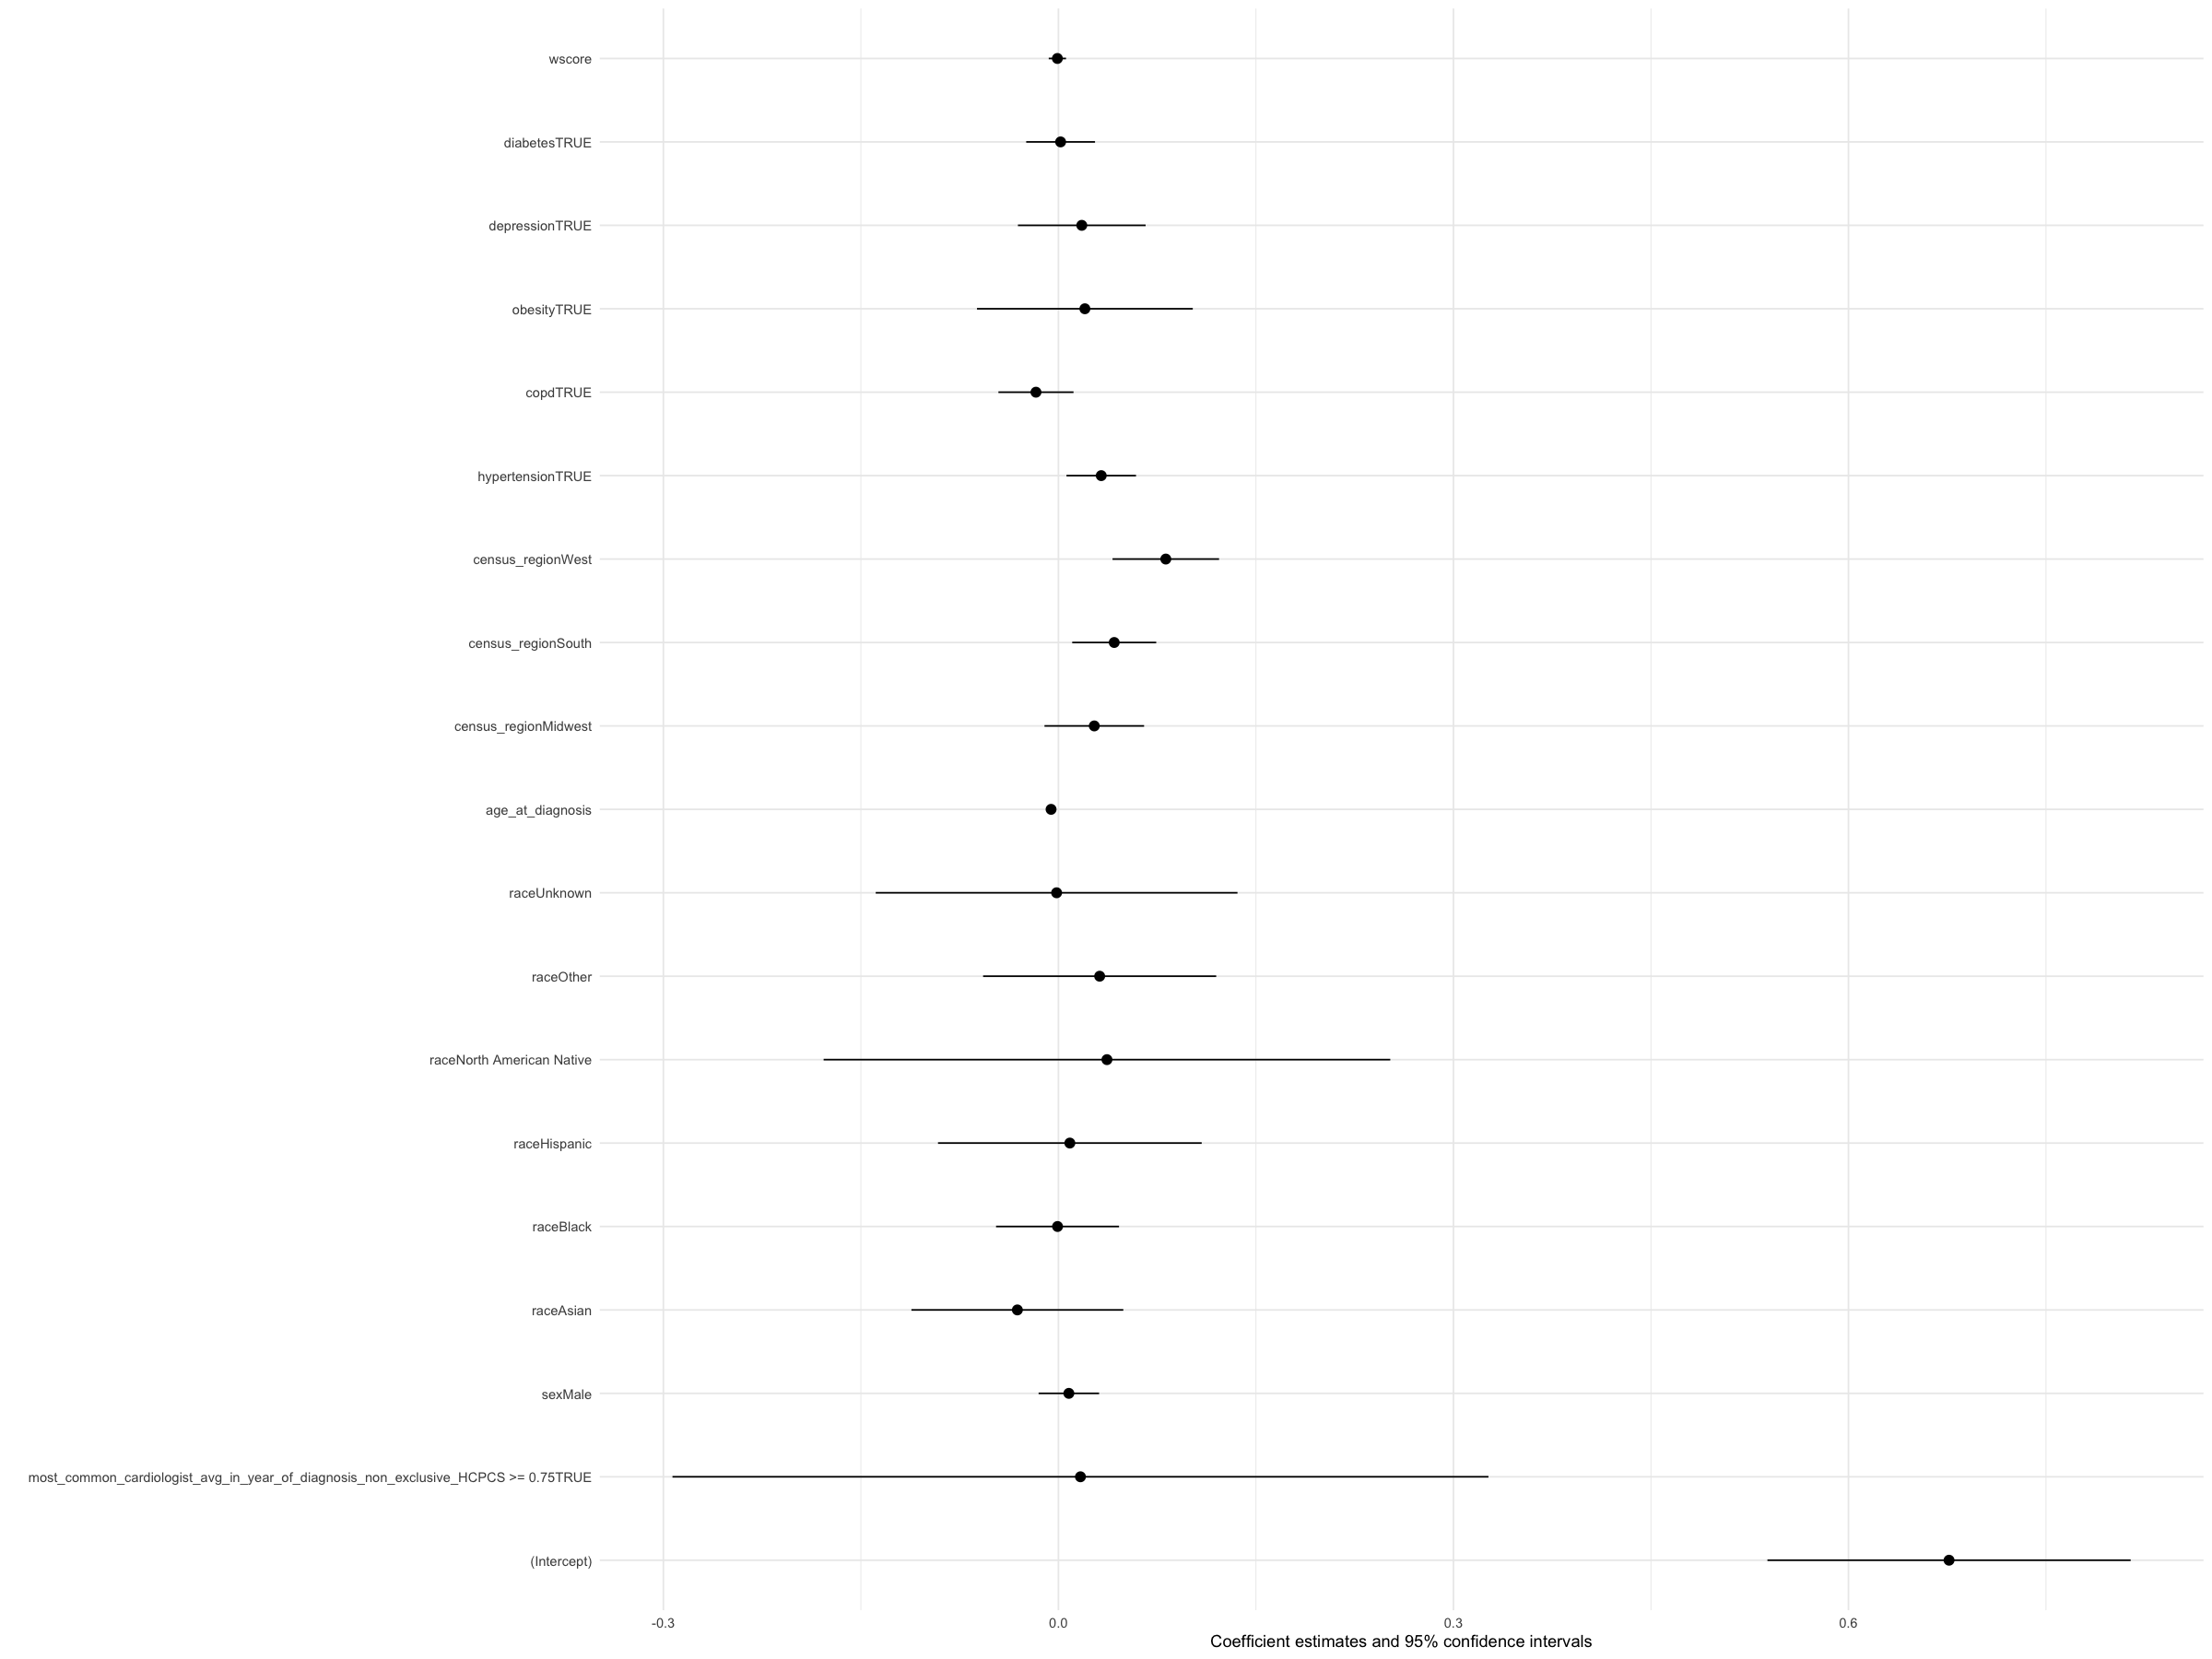

In [82]:
modelplot(ivreg_stress_test)

## Catheterization

In [272]:
ivreg_cath=
ivreg(
  catheterization_count>0~
  (most_common_cardiologist_avg_in_year_of_diagnosis_non_exclusive_HCPCS>=0.75)+
  sex+
  race+
  age_at_diagnosis+
  #census_region+
  hypertension+
  copd+
  obesity+
  depression+
  diabetes
  #wscore
  |
  (most_common_primary_care_physician_2013_avg_in_year_of_diagnosis_non_exclusive_HCPCS>=0.75)+
  sex+
  race+
  age_at_diagnosis+
  #census_region+
  hypertension+
  copd+
  obesity+
  depression+
  diabetes,
  #wscore,
  data = yearly_calculations_stable_angina[most_common_primary_care_physician_2013_avg_in_2013_non_exclusive_HCPCS<0.75,]
)

In [273]:
summary(ivreg_cath)


Call:
ivreg(formula = catheterization_count > 0 ~ (most_common_cardiologist_avg_in_year_of_diagnosis_non_exclusive_HCPCS >= 
    0.75) + sex + race + age_at_diagnosis + hypertension + copd + 
    obesity + depression + diabetes | (most_common_primary_care_physician_2013_avg_in_year_of_diagnosis_non_exclusive_HCPCS >= 
    0.75) + sex + race + age_at_diagnosis + hypertension + copd + 
    obesity + depression + diabetes, data = yearly_calculations_stable_angina[most_common_primary_care_physician_2013_avg_in_2013_non_exclusive_HCPCS < 
    0.75, ])

Residuals:
    Min      1Q  Median      3Q     Max 
-0.7179 -0.3597 -0.2392  0.5747  0.9922 

Coefficients:
                                                                                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)                                                                        1.244047   0.059173  21.024  < 2e-16 ***
most_common_cardiologist_avg_in_year_of_diagnosis_non_exclusive_HCPCS >= 0.75TRUE  0.2178

In [276]:
ivreg_cath_robust=lmtest::coeftest(ivreg_cath,type="HC0",vcov. = sandwich::vcovHC)

In [278]:
ivreg_cath_robust


t test of coefficients:

                                                                                     Estimate  Std. Error  t value  Pr(>|t|)    
(Intercept)                                                                        1.24404656  0.05607183  22.1867 < 2.2e-16 ***
most_common_cardiologist_avg_in_year_of_diagnosis_non_exclusive_HCPCS >= 0.75TRUE  0.21781965  0.14290522   1.5242 0.1274910    
sexMale                                                                            0.04036307  0.01048602   3.8492 0.0001194 ***
raceAsian                                                                         -0.15314156  0.02973350  -5.1505 2.658e-07 ***
raceBlack                                                                         -0.05674978  0.02110517  -2.6889 0.0071831 ** 
raceHispanic                                                                      -0.11410024  0.03861412  -2.9549 0.0031367 ** 
raceNorth American Native                                              

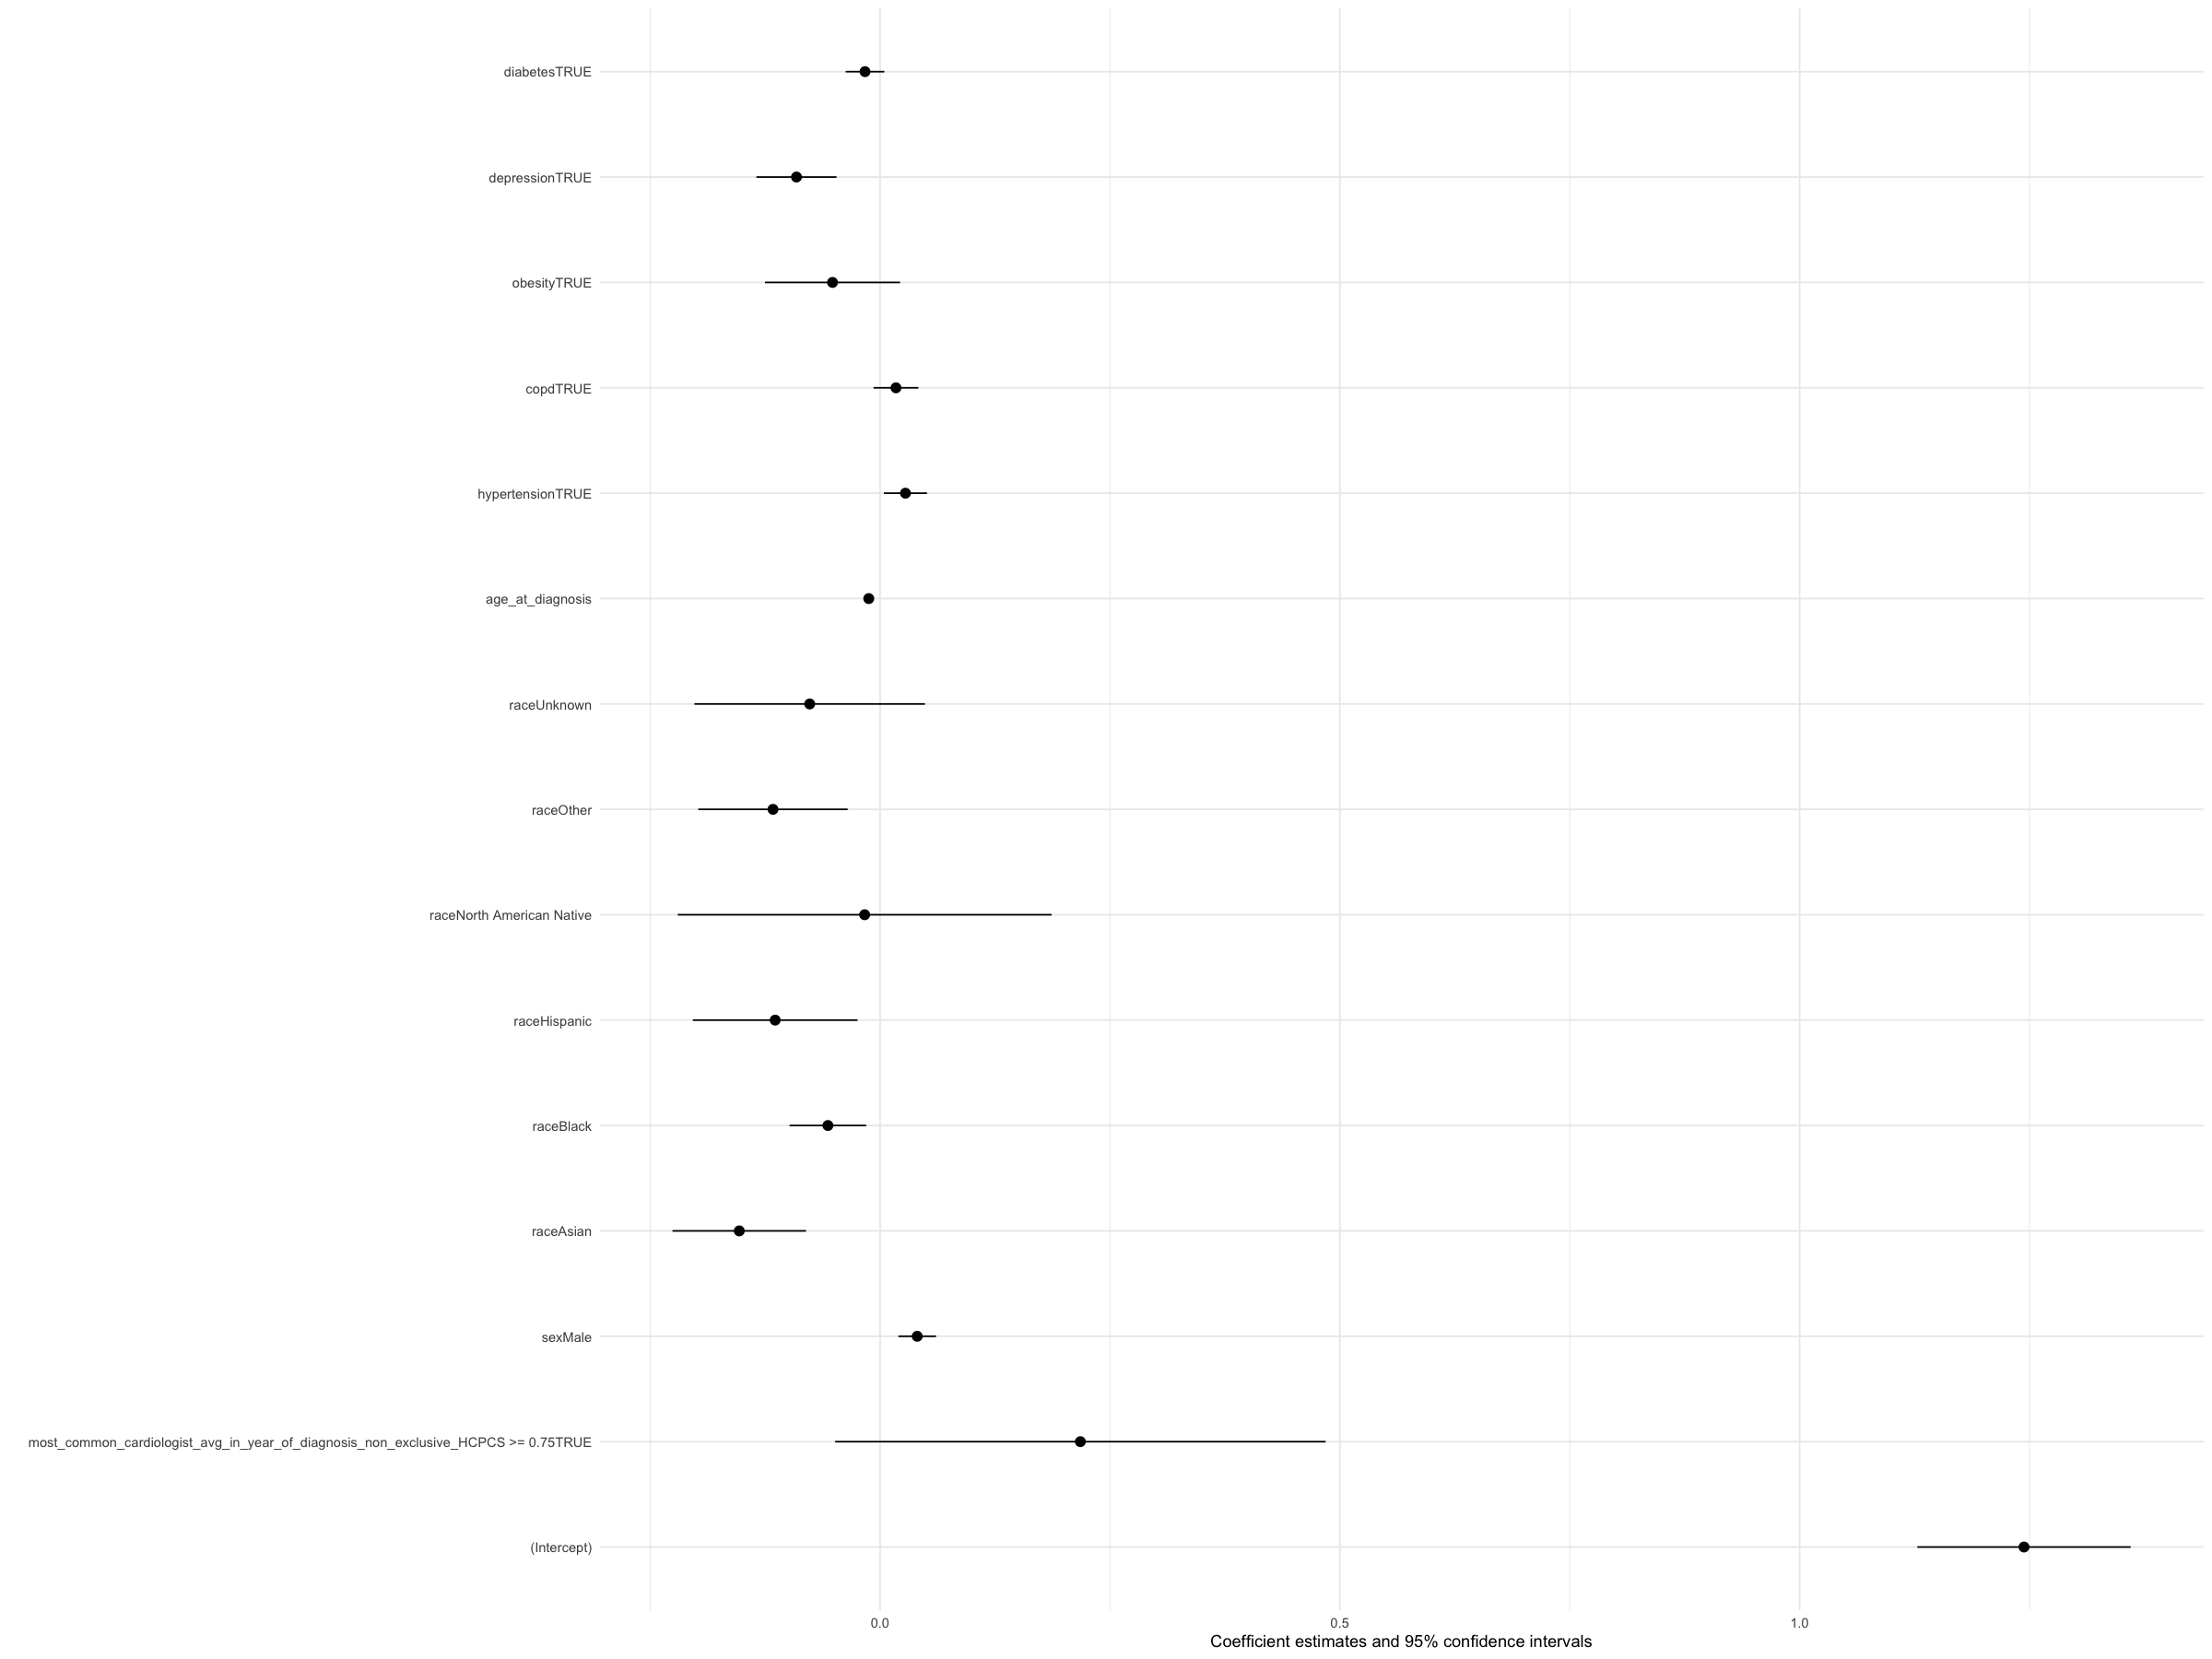

In [274]:
modelplot(ivreg_cath)

## Angioplasty

In [88]:
ivreg_angio=
ivreg(
  angioplasty_count>0~
  (most_common_cardiologist_avg_in_year_of_diagnosis_non_exclusive_HCPCS>=0.75)+
  sex+
  race+
  age_at_diagnosis+
  census_region+
  hypertension+
  copd+
  obesity+
  depression+
  diabetes+
  wscore
  |
  (most_common_primary_care_physician_2013_avg_in_year_of_diagnosis_non_exclusive_HCPCS>=0.75)+
  sex+
  race+
  age_at_diagnosis+
  census_region+
  hypertension+
  copd+
  obesity+
  depression+
  diabetes+
  wscore,
  data = yearly_calculations_stable_angina[most_common_primary_care_physician_2013_avg_in_2013_non_exclusive_HCPCS<0.75,]
)

In [89]:
summary(ivreg_angio)


Call:
ivreg(formula = angioplasty_count > 0 ~ (most_common_cardiologist_avg_in_year_of_diagnosis_non_exclusive_HCPCS >= 
    0.75) + sex + race + age_at_diagnosis + census_region + hypertension + 
    copd + obesity + depression + diabetes + wscore | (most_common_primary_care_physician_2013_avg_in_year_of_diagnosis_non_exclusive_HCPCS >= 
    0.75) + sex + race + age_at_diagnosis + census_region + hypertension + 
    copd + obesity + depression + diabetes + wscore, data = yearly_calculations_stable_angina[most_common_primary_care_physician_2013_avg_in_2013_non_exclusive_HCPCS < 
    0.75, ])

Residuals:
     Min       1Q   Median       3Q      Max 
-0.37618 -0.13288 -0.09675 -0.05589  1.01845 

Coefficients:
                                                                                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)                                                                        0.3367248  0.0491795   6.847 8.24e-12 ***
most_common_cardiologist_avg_in

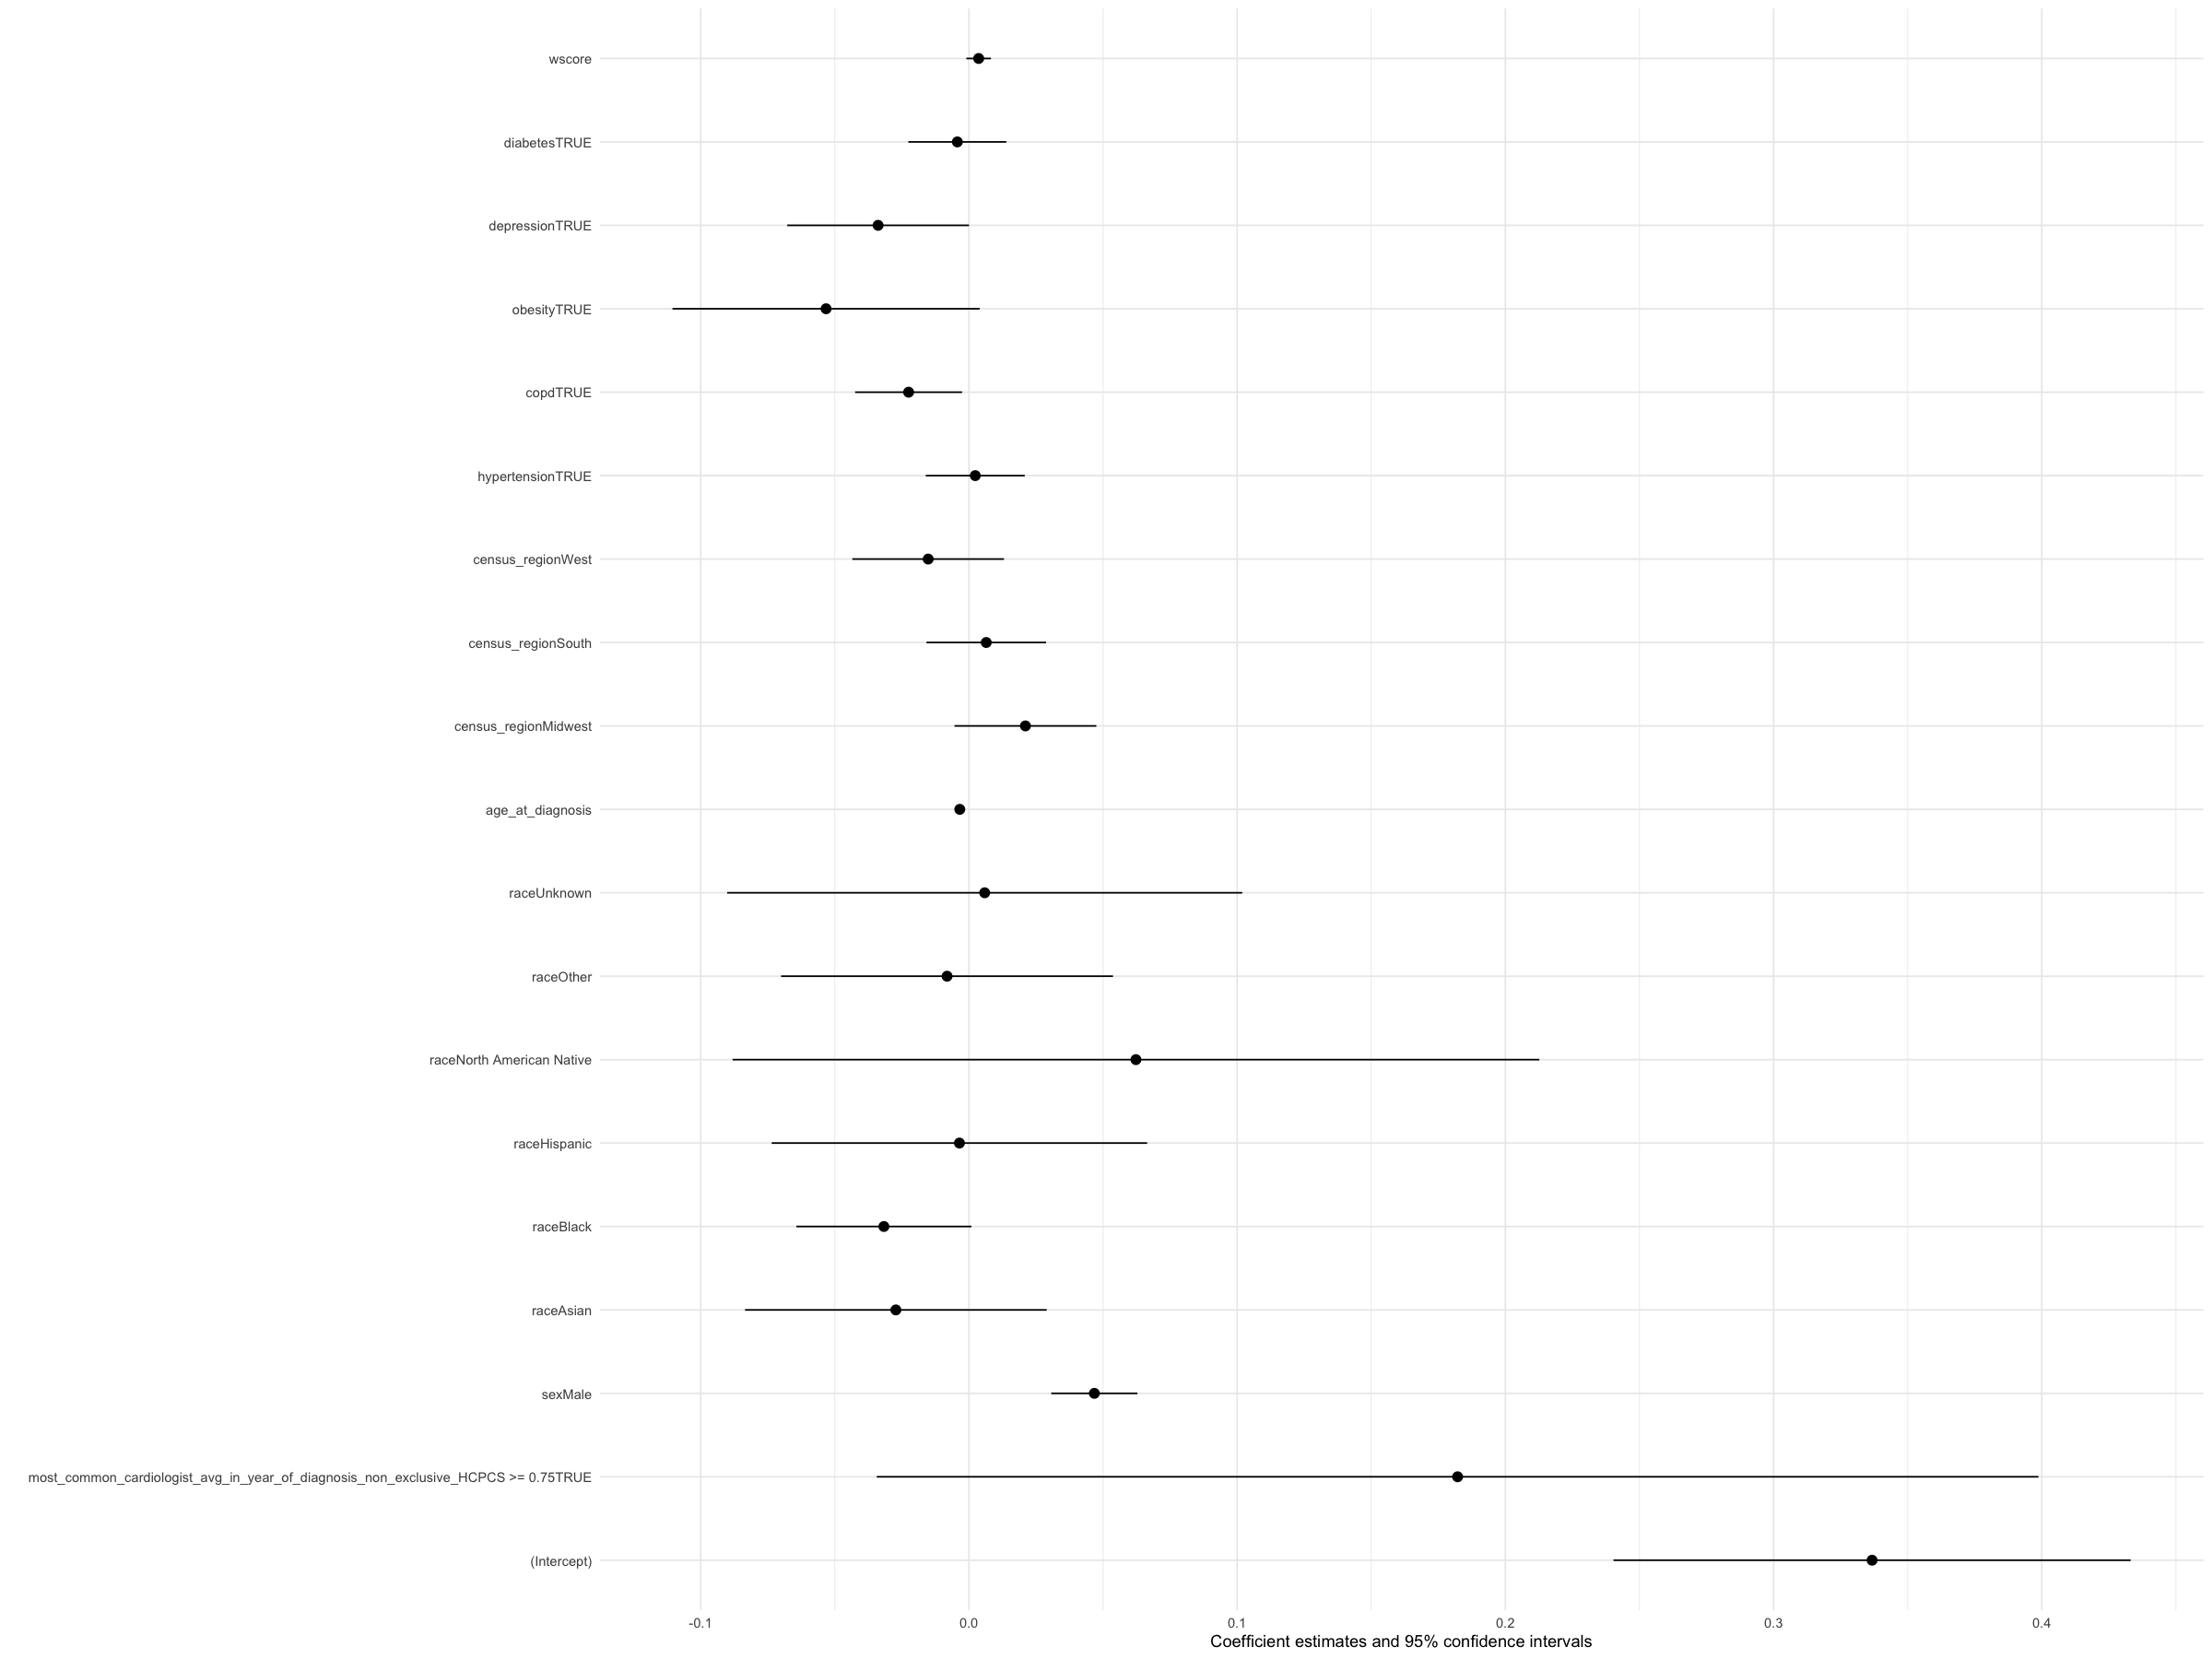

In [90]:
modelplot(ivreg_angio)

In [134]:
library(ggplot2)
model_list=list(
  stress_test=ivreg_stress_test,
  cath=ivreg_cath,
  angio=ivreg_angio)

pdf(width = 10,
    height=4,
    file=("iv_coef_plot.pdf")
   
   )

modelplot(model_list,
          coef_omit = "Intercept|sex|race|age_at_diagnosis|census_region|hypertension|copd|obesity|depression|diabetes|wscore",
          coef_map=c("most_common_cardiologist_avg_in_year_of_diagnosis_non_exclusive_HCPCS >= 0.75TRUE"="Instrument")
         )

dev.off()

pdf 
  2

In [135]:
model_list

$stress_test

Call:
ivreg(formula = stress_test_count > 0 ~ (most_common_cardiologist_avg_in_year_of_diagnosis_non_exclusive_HCPCS >=     0.75) + sex + race + age_at_diagnosis + census_region + hypertension +     copd + obesity + depression + diabetes + wscore | (most_common_primary_care_physician_2013_avg_in_year_of_diagnosis_non_exclusive_HCPCS >=     0.75) + sex + race + age_at_diagnosis + census_region + hypertension +     copd + obesity + depression + diabetes + wscore, data = yearly_calculations_stable_angina[most_common_primary_care_physician_2013_avg_in_2013_non_exclusive_HCPCS <     0.75, ])

Coefficients:
                                                                      (Intercept)  most_common_cardiologist_avg_in_year_of_diagnosis_non_exclusive_HCPCS >= 0.75TRUE                                                                            sexMale  
                                                                        0.6763759                                              

In [275]:
ivreg_stress_test_robust=lmtest::coeftest(ivreg_stress_test,type="HC3",vcov. = sandwich::vcovHC)
ivreg_cath_robust=lmtest::coeftest(ivreg_cath,type="HC3",vcov. = sandwich::vcovHC)
ivreg_angio_robust=lmtest::coeftest(ivreg_angio,type="HC3",vcov. = sandwich::vcovHC)


library(ggplot2)
model_list=list(
  stress_test=ivreg_stress_test_robust,
  cath=ivreg_cath_robust,
  angio=ivreg_angio_robust)

pdf(width = 10,
    height=4,
    file=("iv_coef_plot_robust.pdf")
   
   )

modelplot(model_list,
          coef_omit = "Intercept|sex|race|age_at_diagnosis|census_region|hypertension|copd|obesity|depression|diabetes|wscore",
          coef_map=c("most_common_cardiologist_avg_in_year_of_diagnosis_non_exclusive_HCPCS >= 0.75TRUE"="Instrument")
         )

dev.off()

ERROR: Error in map_estimates(tmp, coef_rename = coef_rename, coef_map = coef_map, : At least one of the term names in each model must appear in `coef_map`.


In [137]:
model_list

$stress_test

t test of coefficients:

                                                                                     Estimate  Std. Error t value  Pr(>|t|)    
(Intercept)                                                                        0.67637594  0.06823349  9.9127 < 2.2e-16 ***
most_common_cardiologist_avg_in_year_of_diagnosis_non_exclusive_HCPCS >= 0.75TRUE  0.01673795  0.15817448  0.1058  0.915729    
sexMale                                                                            0.00792791  0.01175635  0.6744  0.500112    
raceAsian                                                                         -0.03117537  0.04140492 -0.7529  0.451514    
raceBlack                                                                         -0.00066480  0.02414575 -0.0275  0.978036    
raceHispanic                                                                       0.00867878  0.05201076  0.1669  0.867481    
raceNorth American Native                                        

# Crosscheck

In [141]:
auto=readxl::read_excel("auto.xls")

In [144]:
ncol(auto)
nrow(auto)

[1] 12

[1] 74

In [146]:
head(auto)

make,price,mpg,rep78,headroom,trunk,weight,length,turn,displacement,gear_ratio,foreign
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
AMC Concord,4099,22,3,2.5,11,2930,186,40,121,3.58,Domestic
AMC Pacer,4749,17,3,3.0,11,3350,173,40,258,2.53,Domestic
AMC Spirit,3799,22,NA,3.0,12,2640,168,35,121,3.08,Domestic
Buick Century,4816,20,3,4.5,16,3250,196,40,196,2.93,Domestic
Buick Electra,7827,15,4,4.0,20,4080,222,43,350,2.41,Domestic
Buick LeSabre,5788,18,3,4.0,21,3670,218,43,231,2.73,Domestic


In [148]:
ivreg_auto=
ivreg(
  price~
  headroom+
  mpg+
  rep78
  |
  trunk+
  mpg+
  rep78,
  data = auto
)

In [149]:
summary(ivreg_auto)


Call:
ivreg(formula = price ~ headroom + mpg + rep78 | trunk + mpg + 
    rep78, data = auto)

Residuals:
   Min     1Q Median     3Q    Max 
 -3164  -1897   -630   1015   9956 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  8260.24    3270.09   2.526 0.013983 *  
headroom      331.83     704.28   0.471 0.639100    
mpg          -252.06      72.23  -3.490 0.000873 ***
rep78         662.60     350.20   1.892 0.062938 .  

Diagnostic tests:
                 df1 df2 statistic  p-value    
Weak instruments   1  65    32.280 3.39e-07 ***
Wu-Hausman         1  64     1.256    0.267    
Sargan             0  NA        NA       NA    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2616 on 65 degrees of freedom
Multiple R-Squared: 0.2287,	Adjusted R-squared: 0.1931 
Wald test: 7.123 on 3 and 65 DF,  p-value: 0.0003284 


In [157]:
library(sandwich)
library(lmtest)

In [172]:
lmtest::coeftest(ivreg_auto,
                 type="HC0",
                 vcov = vcovCL, 
                 cluster = ~foreign)


t test of coefficients:

            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 8260.239   2986.387  2.7660 0.007381 ** 
headroom     331.833    352.645  0.9410 0.350198    
mpg         -252.062     65.848 -3.8279 0.000293 ***
rep78        662.599    242.268  2.7350 0.008032 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [162]:
library(clubSandwich)

Registered S3 method overwritten by 'clubSandwich':
  method    from    
  bread.mlm sandwich



In [169]:
lmtest::coeftest(ivreg_auto,
                 type="CR0",
                 vcov = vcovCR, 
                 cluster = auto$foreign)


t test of coefficients:

            Estimate Std. Error t value  Pr(>|t|)    
(Intercept) 8260.239   2111.695  3.9117 0.0002217 ***
headroom     331.833    249.358  1.3307 0.1879212    
mpg         -252.062     46.562 -5.4135 9.579e-07 ***
rep78        662.599    171.309  3.8679 0.0002567 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [184]:
ivreg_auto_stage_1=
lm(
  headroom~
  trunk+
  mpg+
  rep78,
  data = auto
)

In [185]:
summary(ivreg_auto_stage_1)


Call:
lm(formula = headroom ~ trunk + mpg + rep78, data = auto)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.31794 -0.45102  0.08821  0.34294  1.67961 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.3594444  0.6086087   2.234    0.029 *  
trunk        0.1279752  0.0225249   5.682 3.39e-07 ***
mpg         -0.0006134  0.0179886  -0.034    0.973    
rep78       -0.0378073  0.0879472  -0.430    0.669    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.6538 on 65 degrees of freedom
  (5 observations deleted due to missingness)
Multiple R-squared:  0.4386,	Adjusted R-squared:  0.4127 
F-statistic: 16.93 on 3 and 65 DF,  p-value: 3.111e-08


In [186]:
predictions_iv_auto=predict(ivreg_auto_stage_1,auto[,c("trunk","mpg","rep78")])
auto$predictions_iv_auto=predictions_iv_auto

In [187]:
ivreg_auto_stage_2=
lm(
  price~
  predictions_iv_auto+
  mpg+
  rep78,
  data = auto
)

In [188]:
summary(ivreg_auto_stage_2)


Call:
lm(formula = price ~ predictions_iv_auto + mpg + rep78, data = auto)

Residuals:
    Min      1Q  Median      3Q     Max 
-3080.3 -1814.9  -587.3   968.5  9990.0 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)          8260.24    3216.81   2.568 0.012542 *  
predictions_iv_auto   331.83     692.81   0.479 0.633568    
mpg                  -252.06      71.05  -3.548 0.000727 ***
rep78                 662.60     344.49   1.923 0.058811 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2574 on 65 degrees of freedom
  (5 observations deleted due to missingness)
Multiple R-squared:  0.2536,	Adjusted R-squared:  0.2191 
F-statistic: 7.361 on 3 and 65 DF,  p-value: 0.0002541
